In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import shap


In [2]:
data = pd.read_csv('final.csv')
data.columns


Index(['GEOID', 'Year', 'RegionName', 'State', 'population', 'poverty.rate',
       'renter.occupied.households', 'pct.renter.occupied',
       'median.gross.rent', 'median.household.income', 'median.property.value',
       'rent.burden', 'pct.white', 'pct.af.am', 'pct.hispanic', 'pct.am.ind',
       'pct.asian', 'pct.nh.pi', 'pct.multiple', 'pct.other',
       'eviction.filings', 'evictions', 'eviction.rate',
       'eviction.filing.rate', 'low.flag', 'imputed', 'subbed', 'RegionID',
       'SizeRank', 'RegionType', 'Metro', 'StateCodeFIPS', 'MunicipalCodeFIPS',
       'ZHVI'],
      dtype='object')

In [3]:
data = pd.read_csv('final.csv')

selected_columns = [
    'poverty.rate', 'pct.renter.occupied', 'median.gross.rent',
    'rent.burden', 'median.household.income', 'eviction.rate', 'population', 'ZHVI'
]

data = data.dropna(subset=selected_columns)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[selected_columns])

pca = PCA(n_components=1)
socioeconomic_index = pca.fit_transform(scaled_data)

data['SEIFA'] = socioeconomic_index

data[['GEOID', 'Year', 'RegionName', 'State', 'SEIFA']]

GEOID  Year       RegionName    State     SEIFA
0       2100  2016   Haines Borough   Alaska  1.188686
1       1001  2008   Autauga County  Alabama  1.511512
2       1001  2009   Autauga County  Alabama  1.399270
3       1001  2011   Autauga County  Alabama  2.049829
4       1001  2012   Autauga County  Alabama  2.153825
...      ...   ...              ...      ...       ...
11683  56041  2016     Uinta County  Wyoming  1.104672
11684  56043  2013  Washakie County  Wyoming  0.305065
11685  56043  2014  Washakie County  Wyoming  0.344891
11686  56043  2015  Washakie County  Wyoming  0.374666
11687  56043  2016  Washakie County  Wyoming  0.448699

[11682 rows x 5 columns]

In [4]:
print(data.columns)

Index(['GEOID', 'Year', 'RegionName', 'State', 'population', 'poverty.rate',
       'renter.occupied.households', 'pct.renter.occupied',
       'median.gross.rent', 'median.household.income', 'median.property.value',
       'rent.burden', 'pct.white', 'pct.af.am', 'pct.hispanic', 'pct.am.ind',
       'pct.asian', 'pct.nh.pi', 'pct.multiple', 'pct.other',
       'eviction.filings', 'evictions', 'eviction.rate',
       'eviction.filing.rate', 'low.flag', 'imputed', 'subbed', 'RegionID',
       'SizeRank', 'RegionType', 'Metro', 'StateCodeFIPS', 'MunicipalCodeFIPS',
       'ZHVI', 'SEIFA'],
      dtype='object')


In [5]:
# data.to_csv('final_with_SEIFA.csv', index=False)

In [6]:
data['Rank'] = data.groupby('Year')['SEIFA'].rank(ascending=False)

data = data.sort_values(['GEOID', 'Year']).reset_index(drop=True)

data['Rank_Change'] = data.groupby('GEOID')['Rank'].diff()

std_dev = data['Rank_Change'].std()
data['Rank_Change_SD'] = std_dev 

data['Classification'] = data['Rank_Change'].apply(
    lambda x: 'Gentrifying' if x > std_dev else 'Not Gentrifying'
)

In [7]:
data

GEOID  Year       RegionName    State  population  poverty.rate  \
0       1001  2008   Autauga County  Alabama       49584          7.52   
1       1001  2009   Autauga County  Alabama       49584          7.52   
2       1001  2011   Autauga County  Alabama       55221          9.28   
3       1001  2012   Autauga County  Alabama       55221          9.28   
4       1001  2013   Autauga County  Alabama       55221          9.28   
...      ...   ...              ...      ...         ...           ...   
11677  56041  2016     Uinta County  Wyoming       20930         10.81   
11678  56043  2013  Washakie County  Wyoming        8400         10.08   
11679  56043  2014  Washakie County  Wyoming        8400         10.08   
11680  56043  2015  Washakie County  Wyoming        8400         10.08   
11681  56043  2016  Washakie County  Wyoming        8400         10.08   

       renter.occupied.households  pct.renter.occupied  median.gross.rent  \
0                            4593                22.45              779.0   
1                            4783                22.45              779.0   
2                            5040                26.08              883.0   
3                            5107                26.08              883.0   
4                            5174                26.08              883.0   
...                           ...                  ...                ...   
11677                        2195                26.95              641.0   
11678                         974                26.25              605.0   
11679                         988                26.25              605.0   
11680                        1002                26.25              605.0   
11681                        1016                26.25              605.0   

       median.household.income  ...  RegionType           Metro  \
0                        51463  ...      county  Montgomery, AL   
1                        51463  ...      county  Montgomery, AL   
2                        51281  ...      county  Montgomery, AL   
3                        51281  ...      county  Montgomery, AL   
4                        51281  ...      county  Montgomery, AL   
...                        ...  ...         ...             ...   
11677                    56569  ...      county    Evanston, WY   
11678                    47652  ...      county             NaN   
11679                    47652  ...      county             NaN   
11680                    47652  ...      county             NaN   
11681                    47652  ...      county             NaN   

       StateCodeFIPS  MunicipalCodeFIPS         ZHVI     SEIFA   Rank  \
0                  1                  1  1957993.489  1.511512  114.0   
1                  1                  1  1908526.012  1.399270  131.0   
2                  1                  1  1771719.315  2.049829  133.0   
3                  1                  1  1779734.674  2.153825  122.0   
4                  1                  1  1823698.983  2.219181  111.0   
...              ...                ...          ...       ...    ...   
11677             56                 41  2258164.400  1.104672  266.0   
11678             56                 43  1821669.197  0.305065  432.0   
11679             56                 43  1837394.906  0.344891  428.0   
11680             56                 43  1905471.802  0.374666  435.0   
11681             56                 43  2003172.800  0.448699  409.0   

       Rank_Change  Rank_Change_SD   Classification  
0              NaN       59.647871  Not Gentrifying  
1             17.0       59.647871  Not Gentrifying  
2              2.0       59.647871  Not Gentrifying  
3            -11.0       59.647871  Not Gentrifying  
4            -11.0       59.647871  Not Gentrifying  
...            ...             ...              ...  
11677         -8.0       59.647871  Not Gentrifying  
11678          NaN       59.647871  Not Gentrifying  
11679         -4.0       

In [8]:
data.Classification.value_counts()

Classification
Not Gentrifying    9956
Gentrifying        1726
Name: count, dtype: int64

In [9]:
# data.isnull().sum()
# data.dropna(inplace=True)
# data.isnull().sum()


In [10]:
data.Classification.value_counts()


Classification
Not Gentrifying    9956
Gentrifying        1726
Name: count, dtype: int64

In [11]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11682 entries, 0 to 11681
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   GEOID                       11682 non-null  int64  
 1   Year                        11682 non-null  int64  
 2   RegionName                  11682 non-null  object 
 3   State                       11682 non-null  object 
 4   population                  11682 non-null  int64  
 5   poverty.rate                11682 non-null  float64
 6   renter.occupied.households  11682 non-null  int64  
 7   pct.renter.occupied         11682 non-null  float64
 8   median.gross.rent           11682 non-null  float64
 9   median.household.income     11682 non-null  int64  
 10  median.property.value       11682 non-null  int64  
 11  rent.burden                 11682 non-null  float64
 12  pct.white                   11682 non-null  float64
 13  pct.af.am                   116

In [12]:
data.describe()


GEOID          Year    population  poverty.rate  \
count  11682.000000  11682.000000  1.168200e+04  11682.000000   
mean   31890.366632   2008.736860  8.581714e+04     11.905116   
std    15186.013708      4.645881  2.553870e+05      5.643165   
min     1001.000000   2000.000000  4.330000e+02      0.000000   
25%    19175.000000   2005.000000  8.330750e+03      7.930000   
50%    32003.000000   2009.000000  1.801800e+04     10.930000   
75%    42099.000000   2013.000000  5.212500e+04     14.660000   
max    56043.000000   2016.000000  5.257001e+06     45.380000   

       renter.occupied.households  pct.renter.occupied  median.gross.rent  \
count                11682.000000         11682.000000       11682.000000   
mean                 11573.209896            26.590812         572.445557   
std                  40296.806692             6.646548         167.603663   
min                     61.000000             7.350000         178.000000   
25%                    800.250000            22.050000         459.000000   
50%                   1797.000000            25.690000         564.000000   
75%                   5915.500000            29.920000         659.000000   
max                 826101.000000            81.030000        1747.000000   

       median.household.income  median.property.value   rent.burden  ...  \
count             11682.000000           1.168200e+04  11682.000000  ...   
mean              41973.158363           1.100817e+05     26.463508  ...   
std               10419.249552           5.968133e+04      4.875019  ...   
min               15805.000000           2.250000e+04      8.300000  ...   
25%               34680.000000           7.420000e+04     23.300000  ...   
50%               41135.000000           9.630000e+04     26.500000  ...   
75%               48065.250000           1.325000e+05     29.600000  ...   
max              112552.000000           1.000001e+06     50.100000  ...   

             subbed      RegionID      SizeRank  StateCodeFIPS  \
count  11682.000000  11682.000000  11682.000000   11682.000000   
mean       0.055470   1574.436740   1799.376905      31.792330   
std        0.228905    899.963267    961.090382      15.176879   
min        0.000000     67.000000      1.000000       1.000000   
25%        0.000000    792.000000    963.000000      19.000000   
50%        0.000000   1569.000000   1975.000000      32.000000   
75%        0.000000   2334.000000   2645.000000      42.000000   
max        1.000000   3275.000000   3212.000000      56.000000   

       MunicipalCodeFIPS          ZHVI         SEIFA          Rank  \
count       11682.000000  1.168200e+04  1.168200e+04  11682.000000   
mean           98.036552  8.666217e+05 -2.919539e-17    355.911402   
std            82.969428  1.026282e+06  1.786198e+00    214.355027   
min             1.000000  0.000000e+00 -4.186121e+00      1.000000   
25%            37.000000  0.000000e+00 -1.212420e+00    172.000000   
50%            81.000000  8.062850e+05 -2.410571e-01    345.000000   
75%           135.000000  1.475364e+06  9.537701e-01    532.000000   
max           505.000000  1.433042e+07  1.079812e+01    822.000000   

        Rank_Change  Rank_Change_SD  
count  10148.000000    1.168200e+04  
mean      17.362239    5.964787e+01  
std       59.647871    1.421146e-14  
min     -495.000000    5.964787e+01  
25%       -9.000000    5.964787e+01  
50%       10.000000    5.964787e+01  
75%       40.000000    5.964787e+01  
max      522.000000    5.964787e+01  

[8 rows x 34 columns]

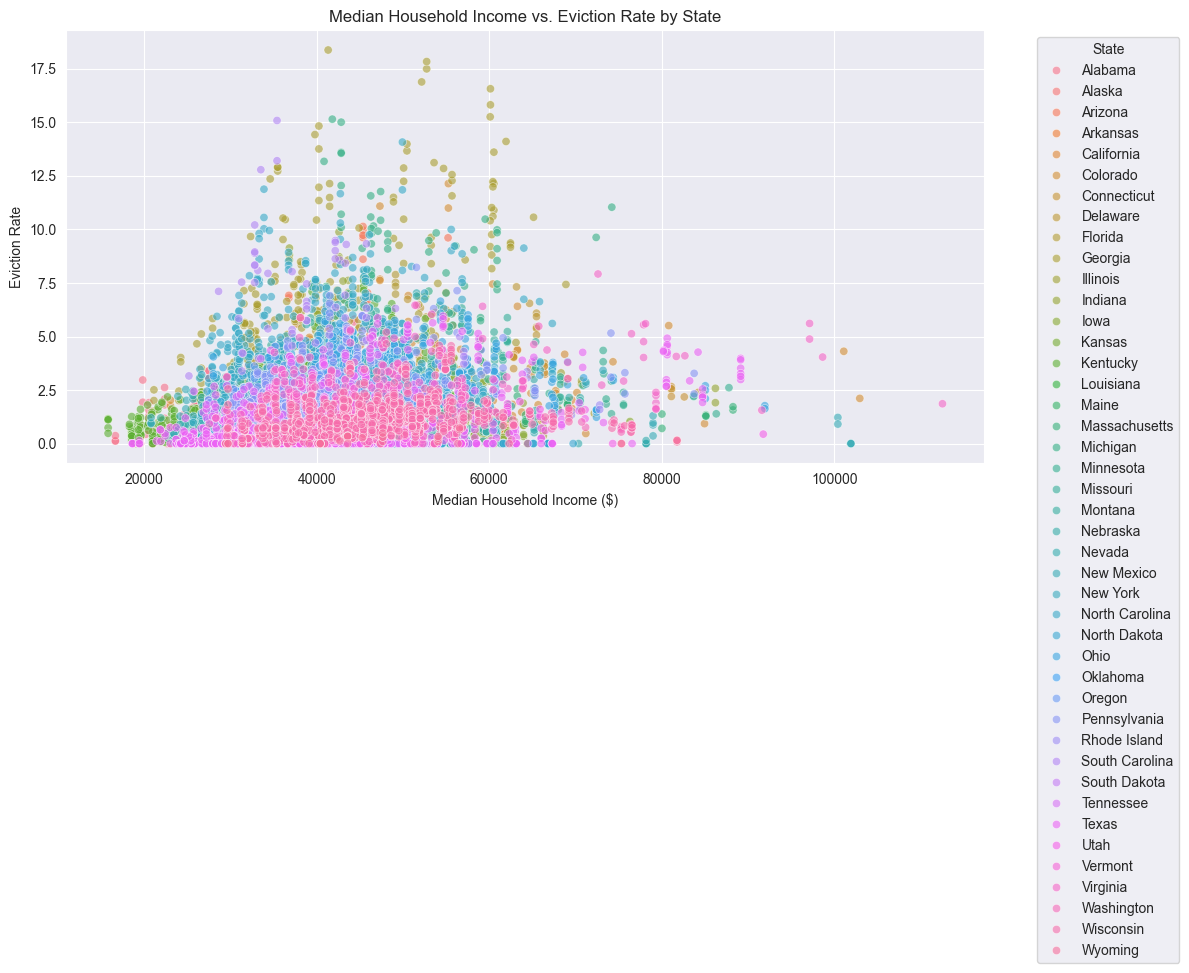

In [13]:
# Scatter Plot of Median Household Income vs. Eviction Rate
plt.figure(figsize=(12, 8))
sns.scatterplot(data=data, x='median.household.income', y='eviction.rate', hue='State', alpha=0.6)
plt.title('Median Household Income vs. Eviction Rate by State')
plt.xlabel('Median Household Income ($)')
plt.ylabel('Eviction Rate')
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

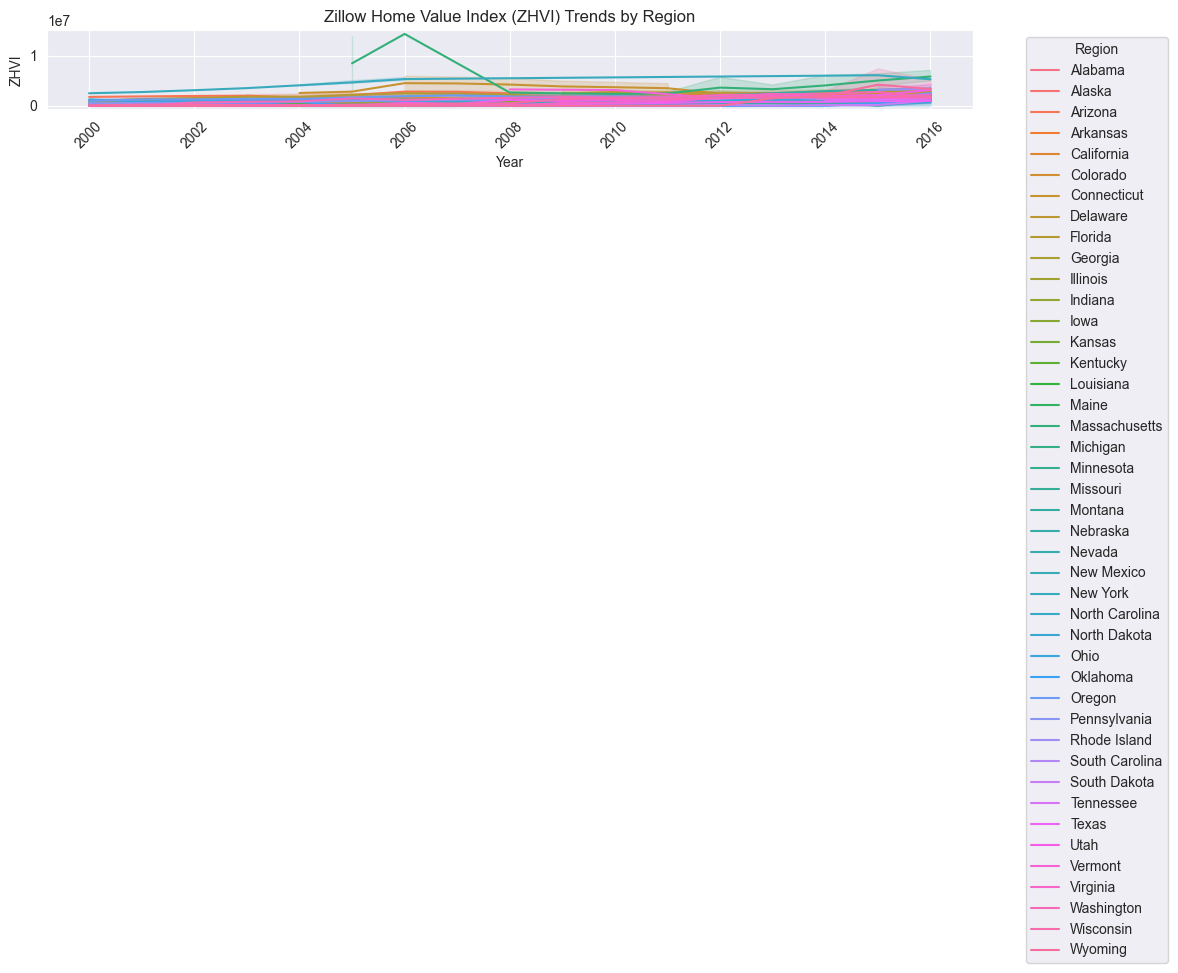

In [14]:
# Time Series Line Plot of ZHVI
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Year', y='ZHVI', hue='State')
plt.title('Zillow Home Value Index (ZHVI) Trends by Region')
plt.ylabel('ZHVI')
plt.xticks(rotation=45)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

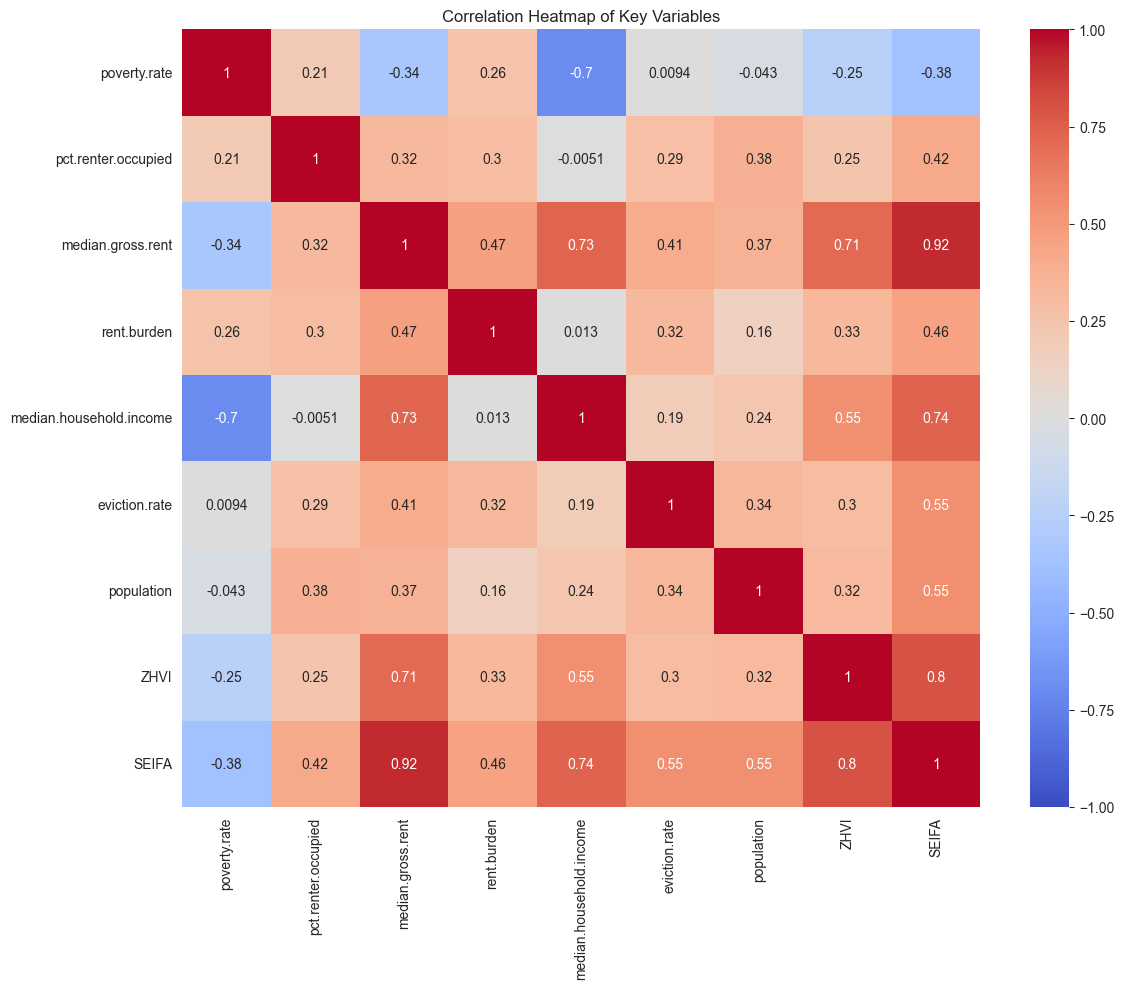

In [15]:
# Heatmap of Correlation Matrix
correlation_matrix = data[['poverty.rate', 'pct.renter.occupied', 'median.gross.rent', 
                           'rent.burden', 'median.household.income', 'eviction.rate', 
                           'population', 'ZHVI', 'SEIFA']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Key Variables')
plt.tight_layout()
plt.show()

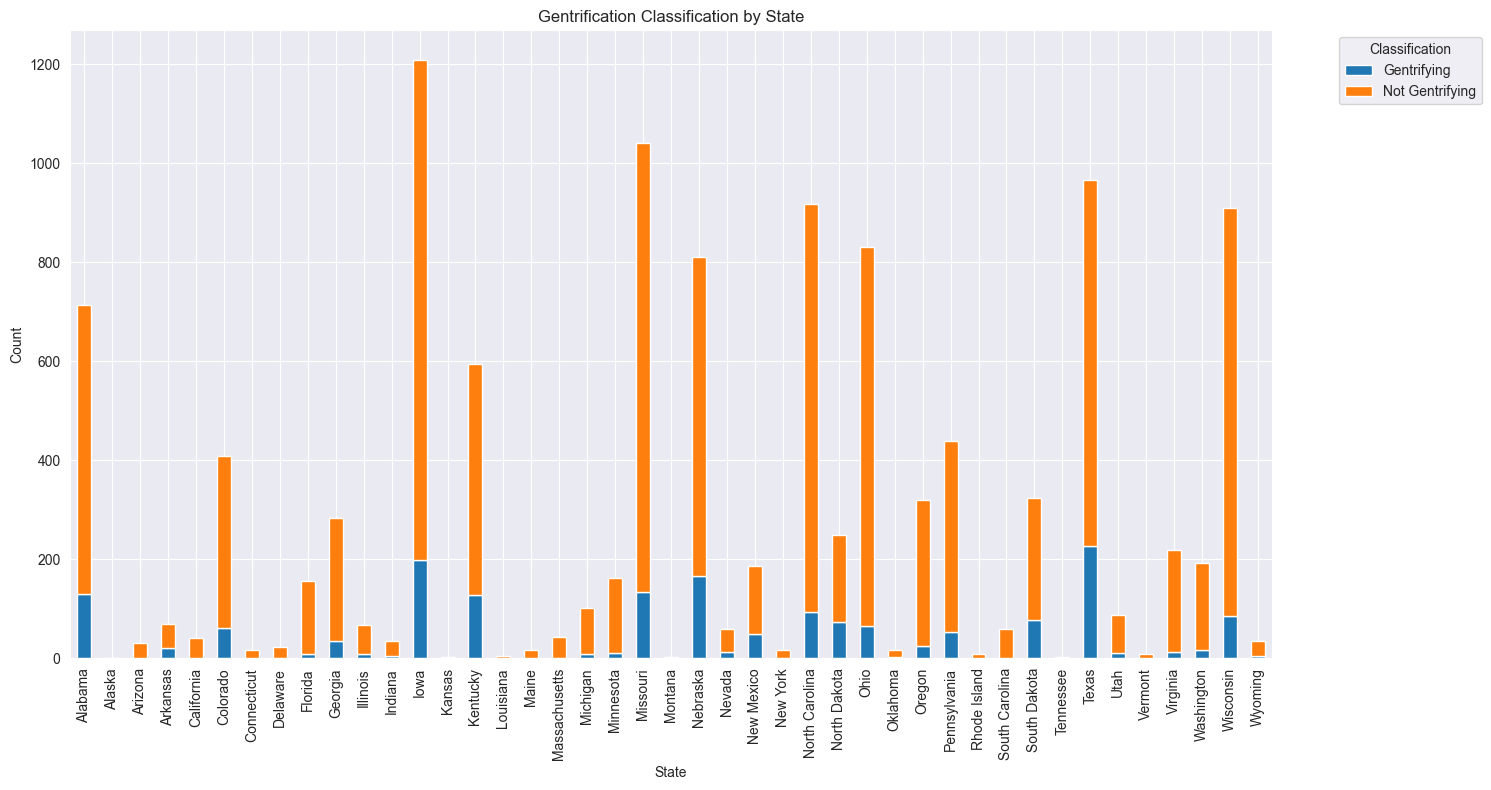

In [16]:
# Bar Plot of Gentrification Classification by State
classification_by_state = data.groupby(['State', 'Classification']).size().unstack()
classification_by_state.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Gentrification Classification by State')
plt.xlabel('State')
plt.ylabel('Count')
plt.legend(title='Classification', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [17]:
# Understand the dataset, identify patterns, and generate hypotheses for modeling.

# Understand Target Variable:
# Distribution of the target variable 'Classification'
data['Classification'].value_counts(normalize=True)

Classification
Not Gentrifying    0.852251
Gentrifying        0.147749
Name: proportion, dtype: float64

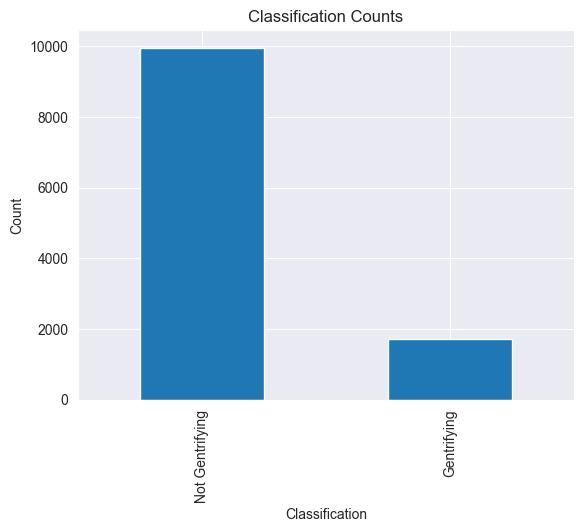

In [18]:
data['Classification'].value_counts().plot(kind='bar', title='Classification Counts')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.show()

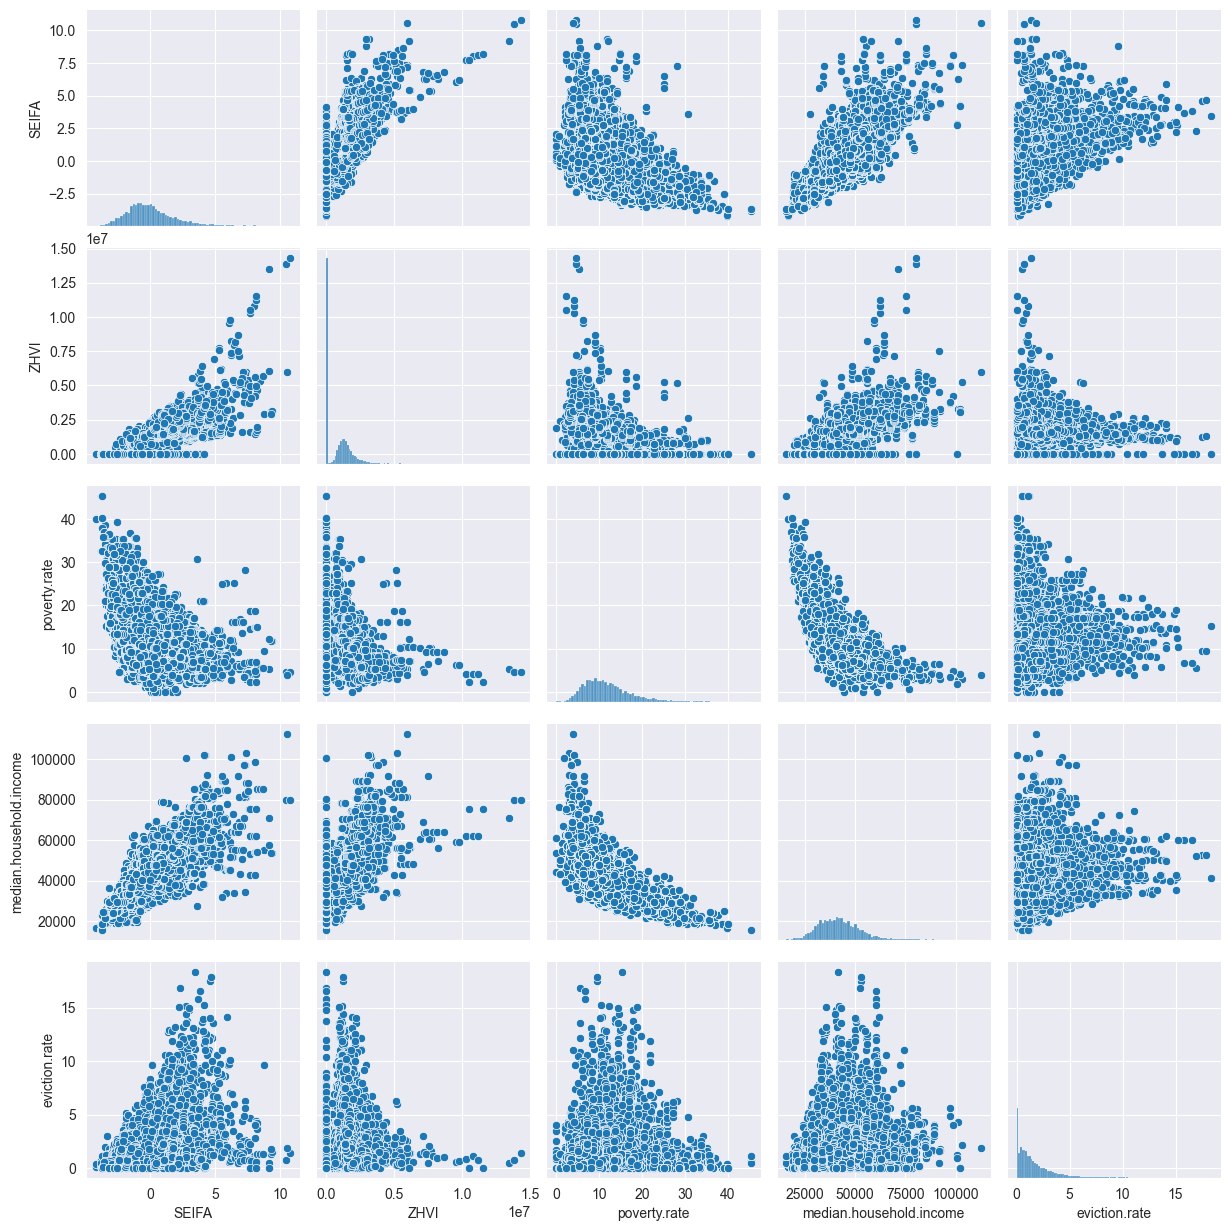

In [19]:
# Feature Relationships: Use pair plots or scatter plots to explore relationships between SEIFA, ZHVI, and other socioeconomic factors.
sns.pairplot(data[['SEIFA', 'ZHVI', 'poverty.rate', 'median.household.income', 'eviction.rate']])
plt.show()

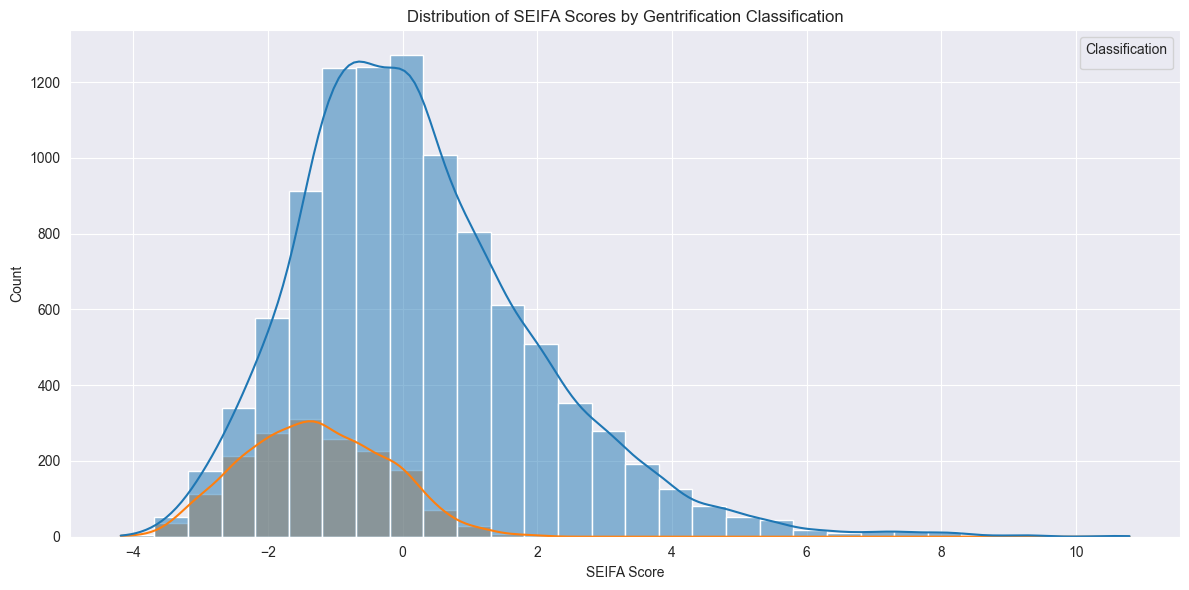

In [20]:
# Distribution of SEIFA Scores by Gentrification Classification
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='SEIFA', hue='Classification', kde=True, bins=30)
plt.title('Distribution of SEIFA Scores by Gentrification Classification')
plt.xlabel('SEIFA Score')
plt.ylabel('Count')
plt.legend(title='Classification')
plt.tight_layout()
plt.show()

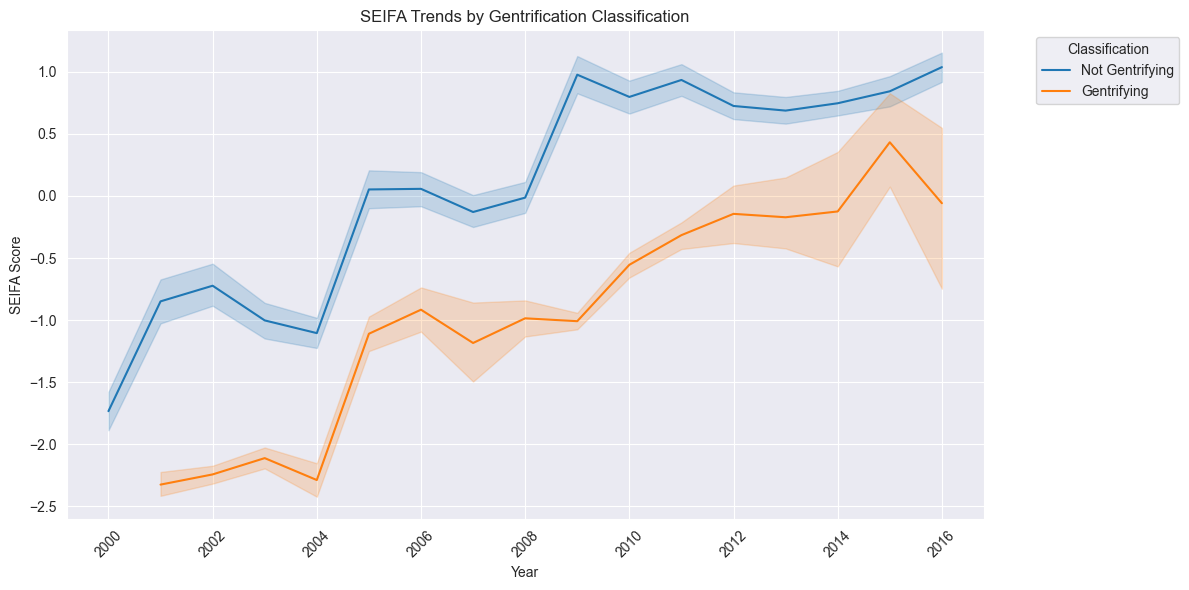

In [21]:
# Analyze how key variables like ZHVI, SEIFA, or eviction.rate change over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Year', y='SEIFA', hue='Classification')
plt.title('SEIFA Trends by Gentrification Classification')
plt.ylabel('SEIFA Score')
plt.xticks(rotation=45)
plt.legend(title='Classification', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

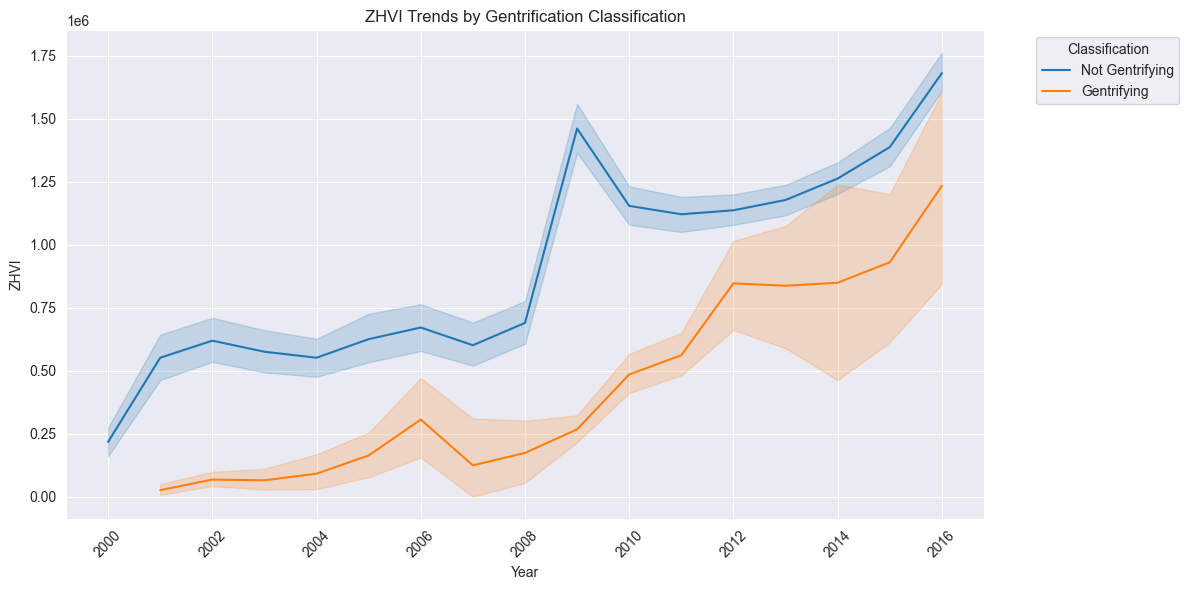

In [22]:
# Analyze how key variables like ZHVI, SEIFA, or eviction.rate change over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Year', y='ZHVI', hue='Classification')
plt.title('ZHVI Trends by Gentrification Classification')
plt.ylabel('ZHVI')
plt.xticks(rotation=45)
plt.legend(title='Classification', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

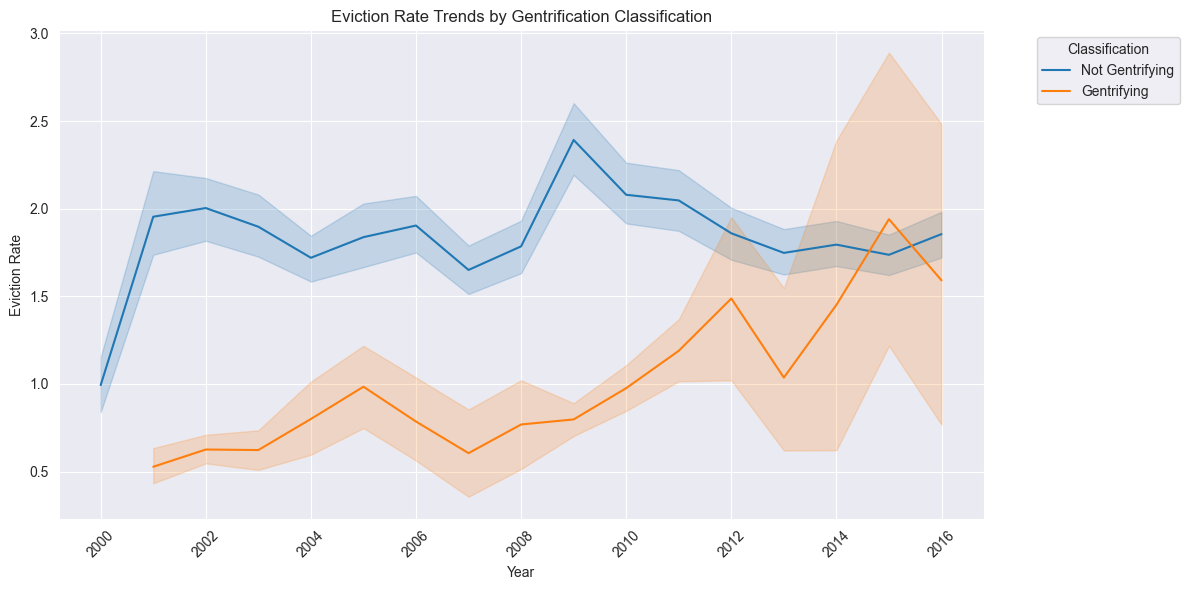

In [23]:
# Analyze how key variables like ZHVI, SEIFA, or eviction.rate change over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Year', y='eviction.rate', hue='Classification')
plt.title('Eviction Rate Trends by Gentrification Classification')
plt.ylabel('Eviction Rate')
plt.xticks(rotation=45)
plt.legend(title='Classification', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

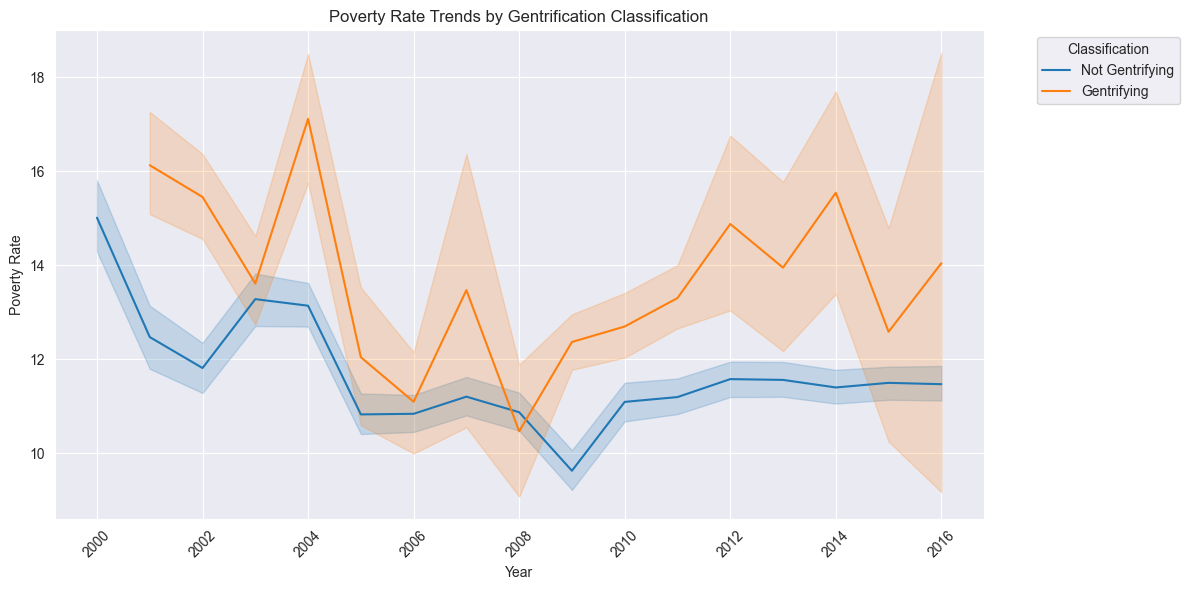

In [24]:
# Analyze how key variables like ZHVI, SEIFA, or eviction.rate change over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Year', y='poverty.rate', hue='Classification')
plt.title('Poverty Rate Trends by Gentrification Classification')   
plt.ylabel('Poverty Rate')
plt.xticks(rotation=45)
plt.legend(title='Classification', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

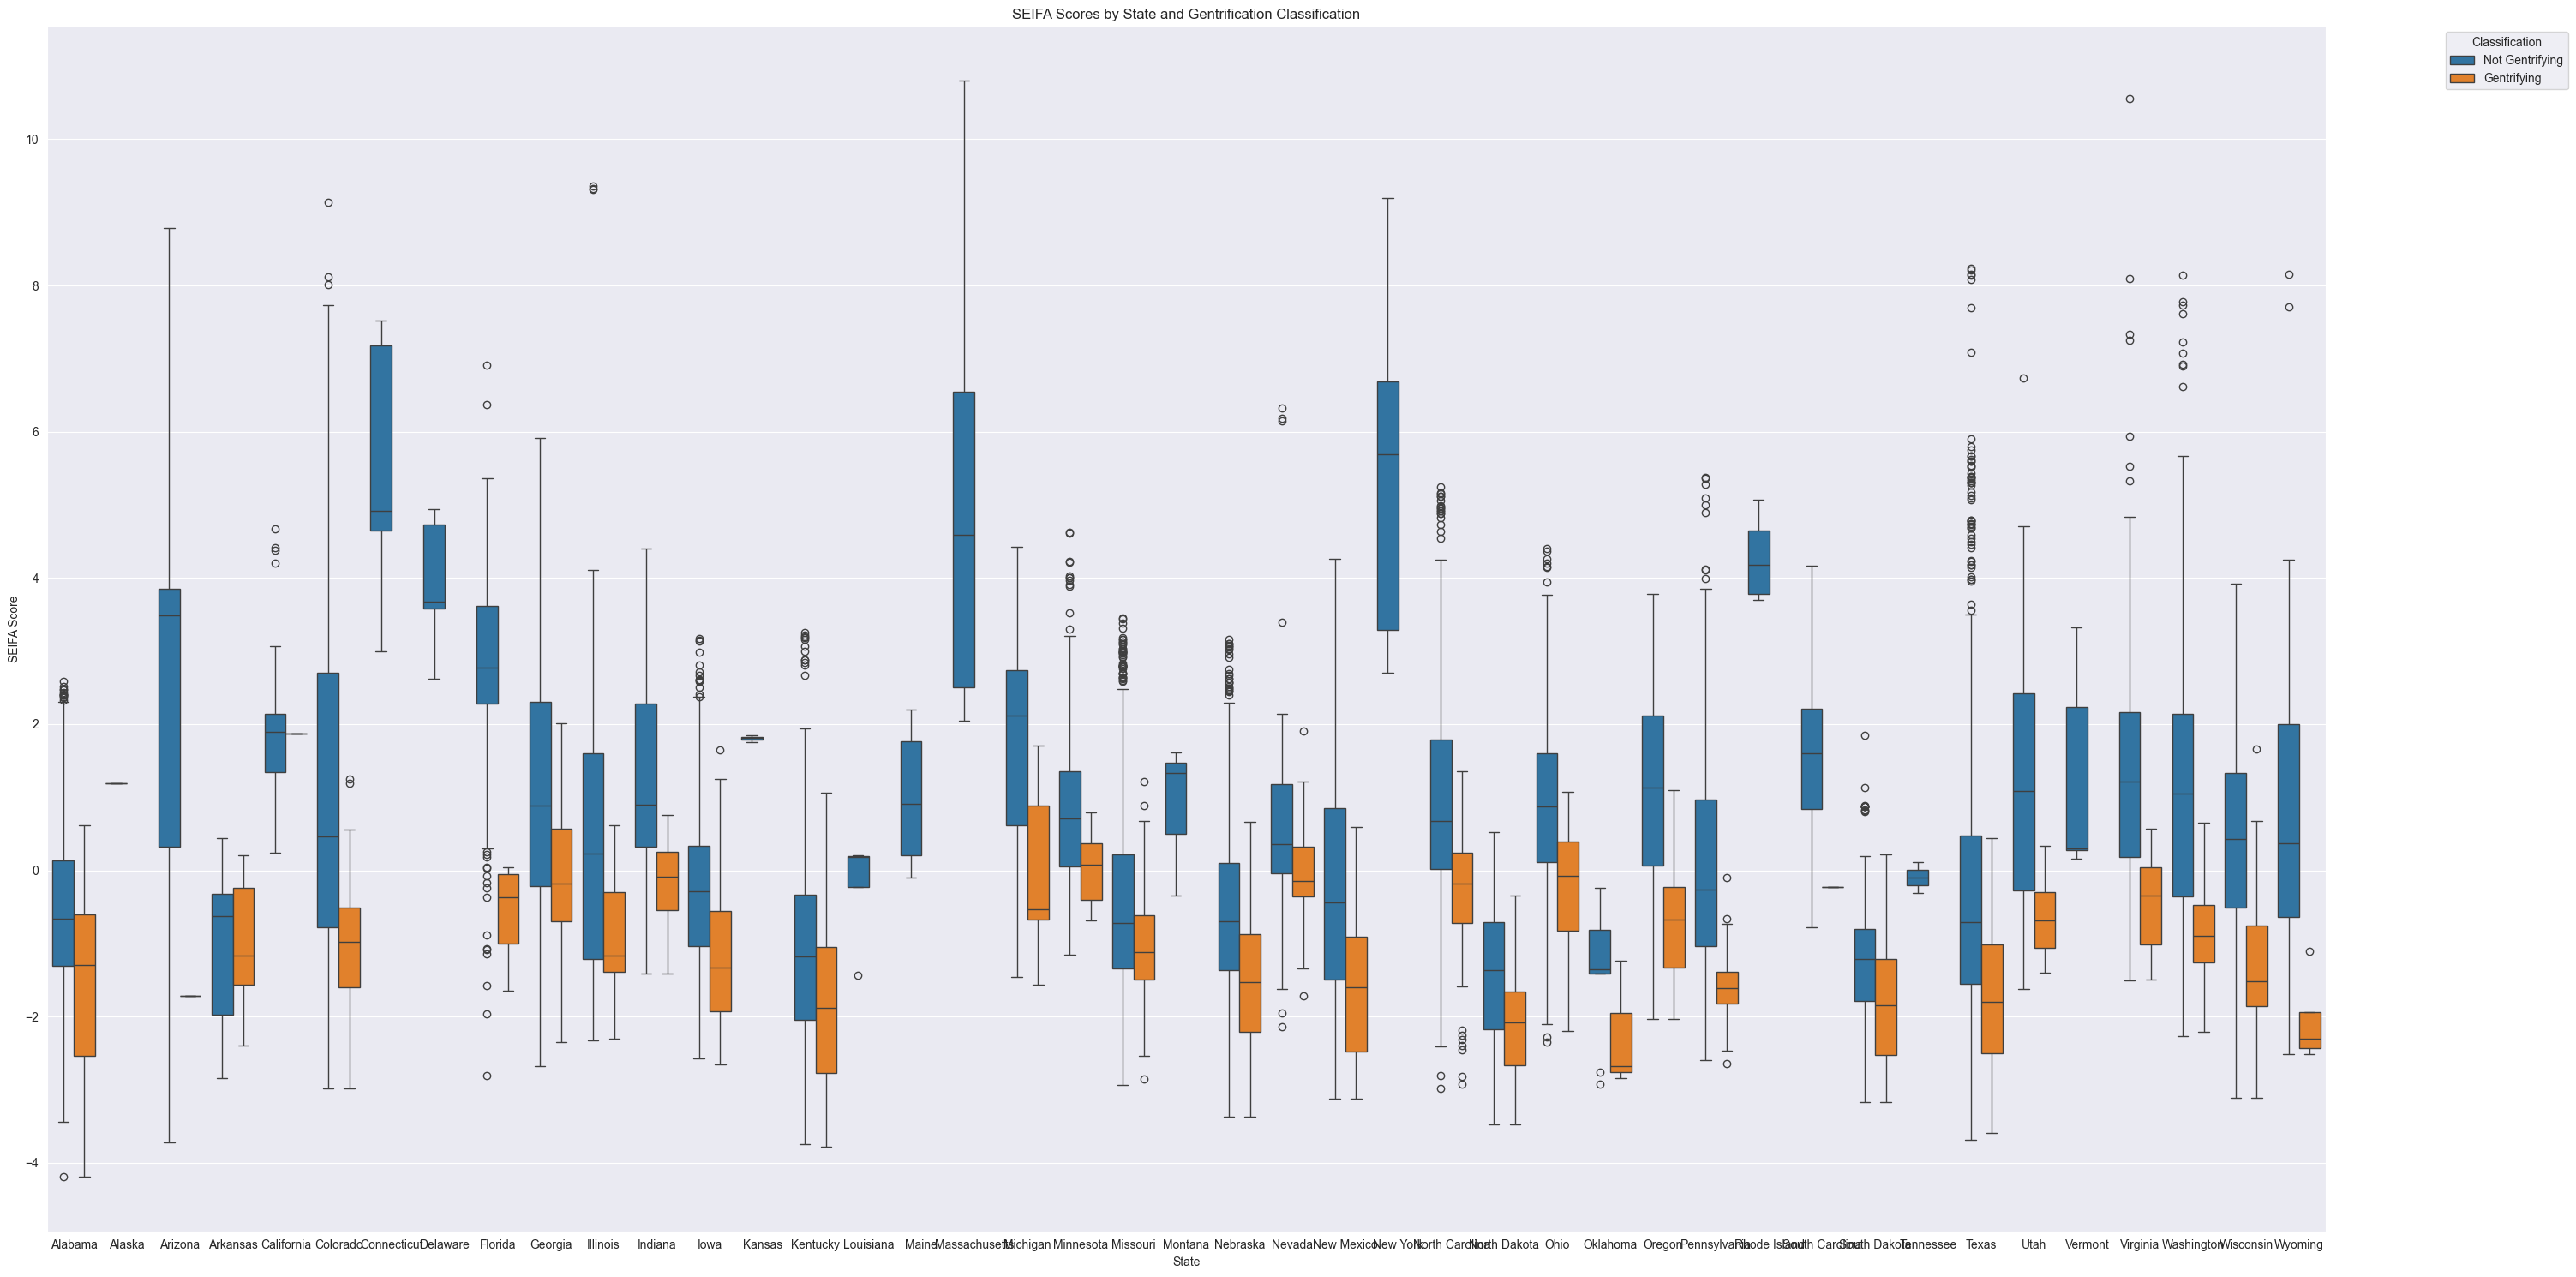

In [25]:
# Geospatial Trends: Plot geospatial data if longitude/latitude is available, or aggregate by regions/states.
plt.figure(figsize=(30,15))
sns.boxplot(data=data, x='State', y='SEIFA', hue='Classification')
plt.title('SEIFA Scores by State and Gentrification Classification')
plt.xlabel('State')
plt.ylabel('SEIFA Score')
plt.legend(title='Classification', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show() 

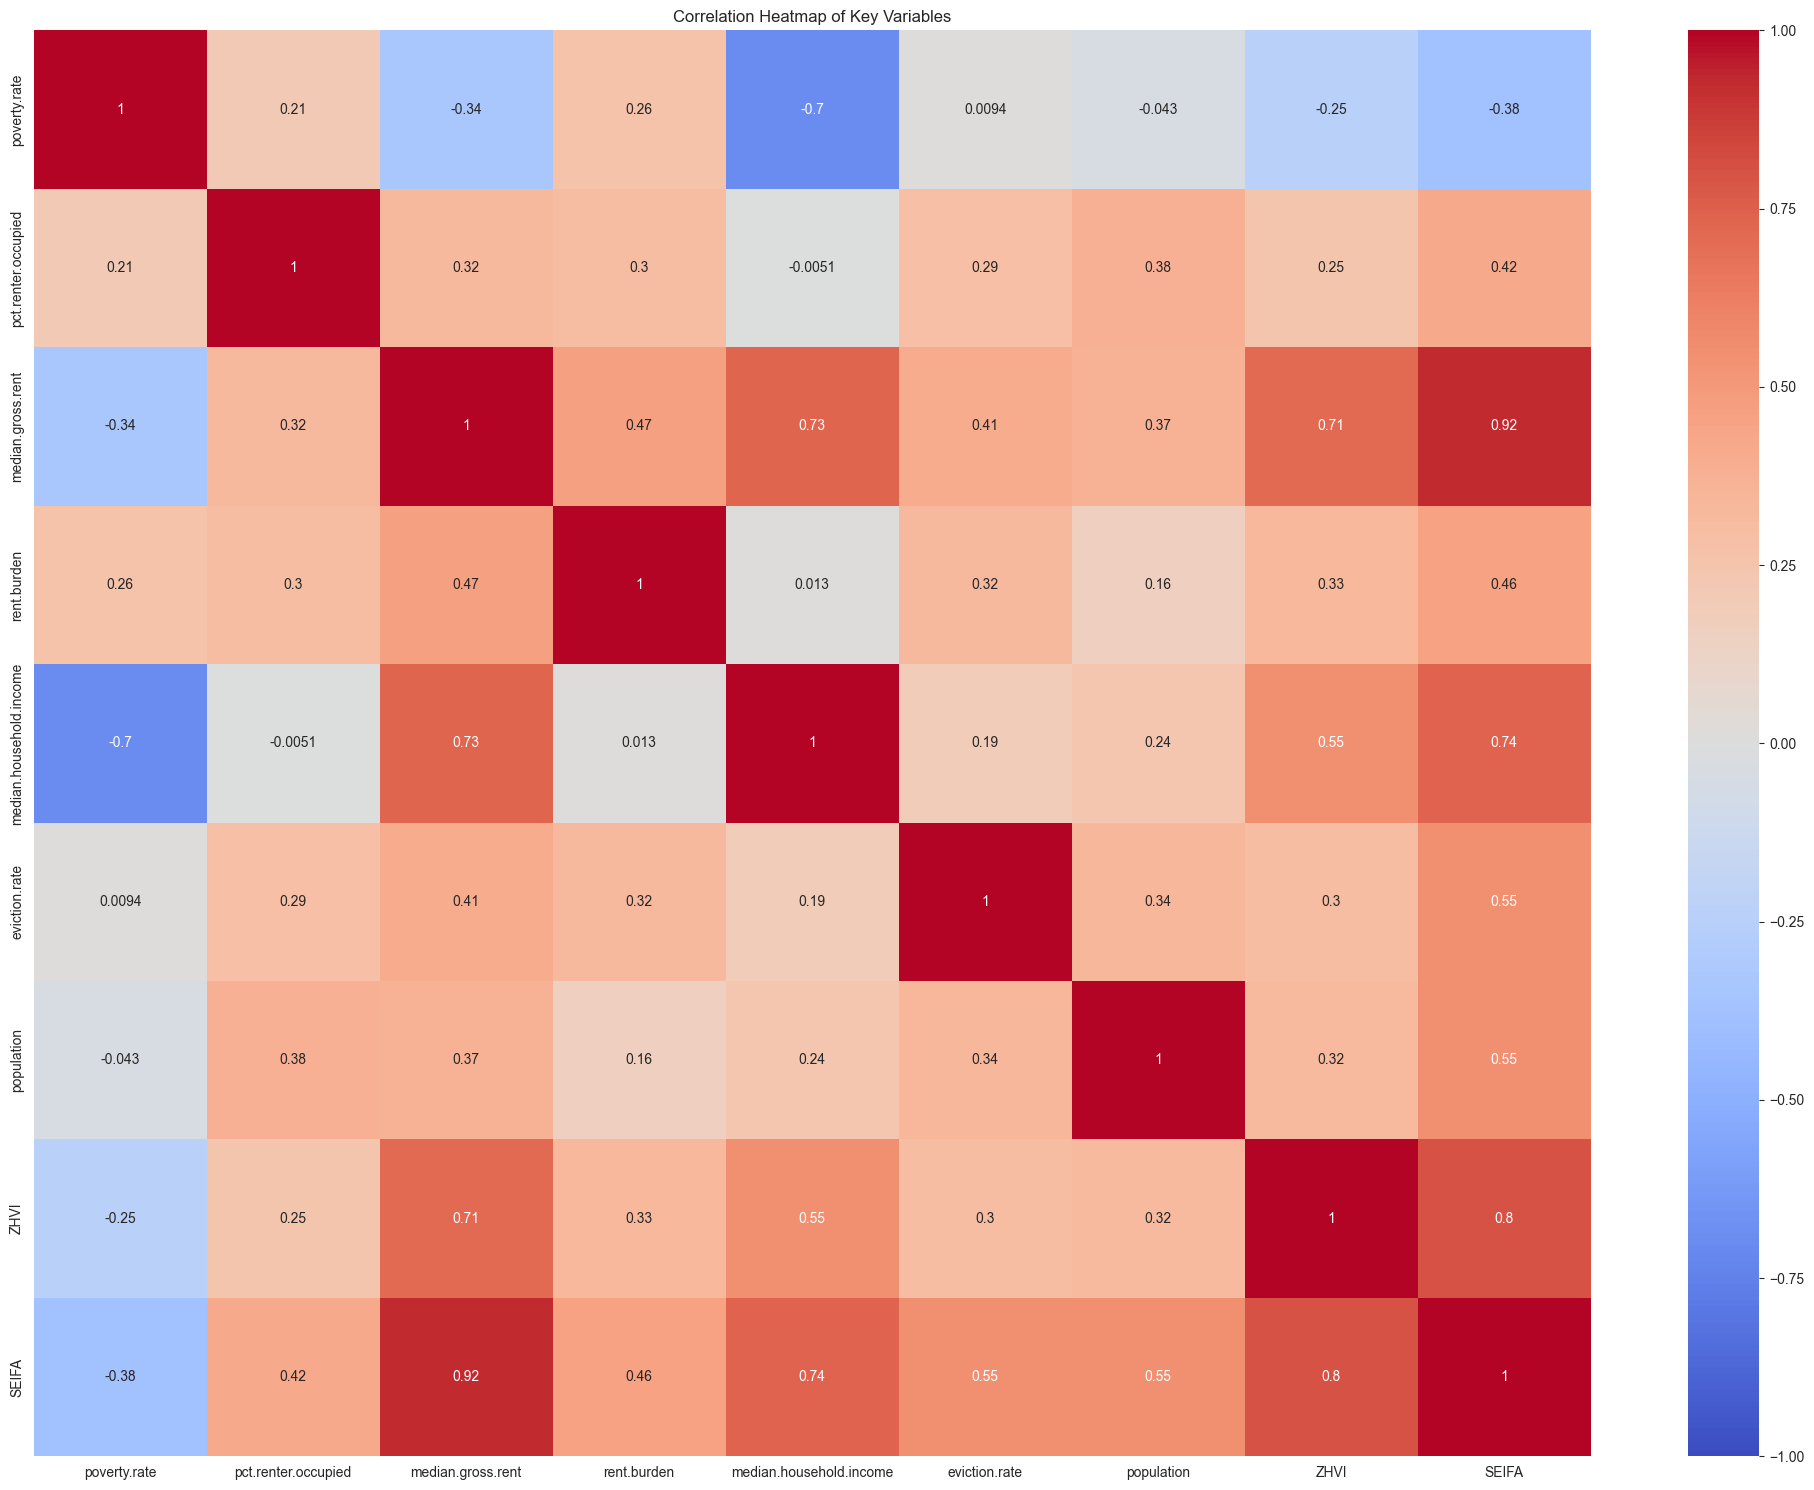

In [26]:
# Check correlations to identify multicollinearity and feature importance
correlation_matrix = data[['poverty.rate', 'pct.renter.occupied', 'median.gross.rent', 
                           'rent.burden', 'median.household.income', 'eviction.rate', 
                           'population', 'ZHVI', 'SEIFA']].corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Key Variables')
plt.tight_layout()
plt.show()


In [27]:
# Step 2: Feature Engineering

# Create new features or transform existing features to improve model performance
# Compute additional metrics such as: rent-to-income ratio, population density, etc.
data['rent_to_income_ratio'] = data['median.gross.rent'] / data['median.household.income']
data['population_density'] = data['population'] / data['ZHVI']

In [28]:
# Year-on-year change in ZHVI or SEIFA (growth rates).
data['ZHVI_growth_rate'] = data.groupby('RegionName')['ZHVI'].pct_change()

In [29]:
# Rolling averages for variables like eviction.rate.
data['eviction_rate_rolling_mean'] = data.groupby('GEOID')['eviction.rate'].rolling(window=3).mean().reset_index(0, drop=True)

In [30]:
# # Encode Categorical Variables: Convert categorical features (e.g., State, RegionType) into numeric values using one-hot encoding or label encoding.
# 
# # One-Hot Encoding for State
# data = pd.get_dummies(data, columns=['State'], drop_first=True)
# 
# # Label Encoding for RegionType
# data['RegionType'] = data['RegionType'].astype('category').cat.codes


In [31]:
print(data.head())

# Print which fetures are correlated with the target variable
# correlation_with_target = data.corr()['Classification'].sort_values(ascending=False)

   GEOID  Year      RegionName    State  population  poverty.rate  \
0   1001  2008  Autauga County  Alabama       49584          7.52   
1   1001  2009  Autauga County  Alabama       49584          7.52   
2   1001  2011  Autauga County  Alabama       55221          9.28   
3   1001  2012  Autauga County  Alabama       55221          9.28   
4   1001  2013  Autauga County  Alabama       55221          9.28   

   renter.occupied.households  pct.renter.occupied  median.gross.rent  \
0                        4593                22.45              779.0   
1                        4783                22.45              779.0   
2                        5040                26.08              883.0   
3                        5107                26.08              883.0   
4                        5174                26.08              883.0   

   median.household.income  ...         ZHVI     SEIFA   Rank  Rank_Change  \
0                    51463  ...  1957993.489  1.511512  114.0       

In [32]:
# print columns inside the data

print(data.columns)


Index(['GEOID', 'Year', 'RegionName', 'State', 'population', 'poverty.rate',
       'renter.occupied.households', 'pct.renter.occupied',
       'median.gross.rent', 'median.household.income', 'median.property.value',
       'rent.burden', 'pct.white', 'pct.af.am', 'pct.hispanic', 'pct.am.ind',
       'pct.asian', 'pct.nh.pi', 'pct.multiple', 'pct.other',
       'eviction.filings', 'evictions', 'eviction.rate',
       'eviction.filing.rate', 'low.flag', 'imputed', 'subbed', 'RegionID',
       'SizeRank', 'RegionType', 'Metro', 'StateCodeFIPS', 'MunicipalCodeFIPS',
       'ZHVI', 'SEIFA', 'Rank', 'Rank_Change', 'Rank_Change_SD',
       'Classification', 'rent_to_income_ratio', 'population_density',
       'ZHVI_growth_rate', 'eviction_rate_rolling_mean'],
      dtype='object')


In [33]:
import pandas as pd

# Describe the data for numerical columns only
numerical_data = data.select_dtypes(include=['int64', 'float64'])

# Look for columns with high variance or large ranges
wide_range_columns = [col for col in numerical_data.columns if numerical_data[col].max() - numerical_data[col].min() > 1000]
print("Columns with wide ranges:", wide_range_columns)



Columns with wide ranges: ['GEOID', 'population', 'renter.occupied.households', 'median.gross.rent', 'median.household.income', 'median.property.value', 'eviction.filings', 'evictions', 'RegionID', 'SizeRank', 'ZHVI', 'Rank_Change', 'population_density', 'ZHVI_growth_rate']


In [34]:
# Ensure numeric features (e.g., poverty.rate, median.gross.rent) are scaled for consistent model performance.
scaler = StandardScaler()

data_scaled = scaler.fit_transform(data[['population', 'poverty.rate',
       'renter.occupied.households', 'pct.renter.occupied',
       'median.gross.rent', 'median.household.income', 'median.property.value',
       'rent.burden', 'pct.white', 'pct.af.am', 'pct.hispanic', 'pct.am.ind',
       'pct.asian', 'pct.nh.pi', 'pct.multiple', 'pct.other',
       'eviction.filings', 'evictions', 'eviction.rate',
       'eviction.filing.rate',
       'ZHVI']])

# data_scaled = scaler.fit_transform(data[['population', 'renter.occupied.households', 'median.gross.rent', 'median.household.income', 'median.property.value', 'eviction.filings', 'evictions', 'SizeRank', 'ZHVI']])

In [35]:
# total number of observations
print(data.shape[0])

#no of observations that has NaN values- only for Classification column

# Check for NaN values in the 'Classification' column
nan_count = data['Classification'].isna().sum()

# Print the result
print(f"Number of observations with NaN in 'Classification' column: {nan_count}")


11682
Number of observations with NaN in 'Classification' column: 0


In [36]:
# Perform PCA to reduce dimensionality and capture key components of the data.
pca = PCA(n_components=0.95)
data_pca = pca.fit_transform(data_scaled) 


# Number of components to explain 95% of the variance
print("Number of components:", pca.n_components_)

# Create the DataFrame with PCA components and ensure 'Classification' is aligned correctly
data_preprocessed = pd.DataFrame(data_pca, columns=[f'PCA_{i+1}' for i in range(data_pca.shape[1])])

# Ensure that the 'Classification' column is properly added back to the new DataFrame
data_preprocessed['Classification'] = data['Classification'].values

# Check the first few rows to ensure the 'Classification' column is properly added
print(data_preprocessed.head())

# Total number of observations after PCA and adding 'Classification' column
print(data_preprocessed.shape[0])

# Check for NaN values in the 'Classification' column again
nan_count = data_preprocessed['Classification'].isna().sum()
print(f"Number of observations with NaN in 'Classification' column: {nan_count}")


Number of components: 13
      PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6     PCA_7  \
0  0.647755 -1.353656  0.820595  0.520270  0.655650  0.231263 -0.748833   
1  0.526355 -1.374819  0.756184  0.327835  0.650820  0.130640 -0.880592   
2  1.274329 -1.218955  1.598129  0.133237  0.334631 -0.360078 -1.086385   
3  1.425007 -1.173116  1.667331  0.388091  0.338532 -0.224839 -0.902813   
4  1.483074 -1.170094  1.696032  0.467121  0.340756 -0.184893 -0.853336   

      PCA_8     PCA_9    PCA_10    PCA_11    PCA_12    PCA_13   Classification  
0 -0.389768  0.744728 -0.105860 -0.576737 -0.401214 -0.126494  Not Gentrifying  
1 -0.408691  0.789281 -0.057413 -0.633187 -0.430704 -0.179383  Not Gentrifying  
2 -0.269142  0.317069  0.030271 -0.731266 -0.006992 -0.727017  Not Gentrifying  
3 -0.239632  0.263408 -0.020129 -0.670926  0.041624 -0.684165  Not Gentrifying  
4 -0.234294  0.242434 -0.046781 -0.642632  0.049330 -0.651576  Not Gentrifying  
11682
Number of observations with NaN 

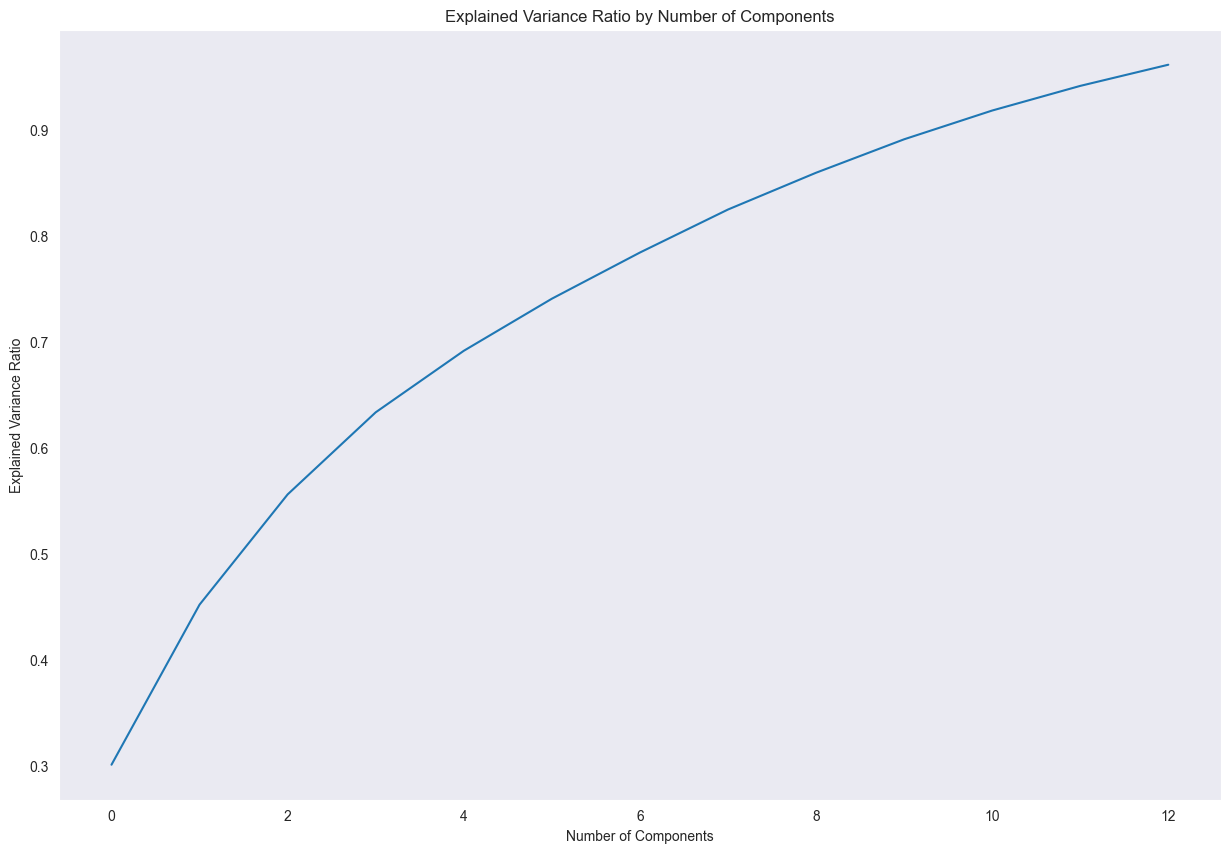

In [37]:
# Visualize the explained variance ratio of PCA components
plt.figure(figsize=(15, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Number of Components')
plt.grid()
plt.show()


In [38]:
# Handle Class Imbalance: If Classification is imbalanced, use techniques like oversampling (SMOTE) or assign class weights in models.
data_preprocessed['Classification'].value_counts()


Classification
Not Gentrifying    9956
Gentrifying        1726
Name: count, dtype: int64

In [39]:
data_preprocessed.head()

PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6     PCA_7  \
0  0.647755 -1.353656  0.820595  0.520270  0.655650  0.231263 -0.748833   
1  0.526355 -1.374819  0.756184  0.327835  0.650820  0.130640 -0.880592   
2  1.274329 -1.218955  1.598129  0.133237  0.334631 -0.360078 -1.086385   
3  1.425007 -1.173116  1.667331  0.388091  0.338532 -0.224839 -0.902813   
4  1.483074 -1.170094  1.696032  0.467121  0.340756 -0.184893 -0.853336   

      PCA_8     PCA_9    PCA_10    PCA_11    PCA_12    PCA_13   Classification  
0 -0.389768  0.744728 -0.105860 -0.576737 -0.401214 -0.126494  Not Gentrifying  
1 -0.408691  0.789281 -0.057413 -0.633187 -0.430704 -0.179383  Not Gentrifying  
2 -0.269142  0.317069  0.030271 -0.731266 -0.006992 -0.727017  Not Gentrifying  
3 -0.239632  0.263408 -0.020129 -0.670926  0.041624 -0.684165  Not Gentrifying  
4 -0.234294  0.242434 -0.046781 -0.642632  0.049330 -0.651576  Not Gentrifying

In [40]:
data_preprocessed['Classification'] = data_preprocessed['Classification'].map({'Not Gentrifying': 0, 'Gentrifying': 1})


In [41]:
data_preprocessed.head()

PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6     PCA_7  \
0  0.647755 -1.353656  0.820595  0.520270  0.655650  0.231263 -0.748833   
1  0.526355 -1.374819  0.756184  0.327835  0.650820  0.130640 -0.880592   
2  1.274329 -1.218955  1.598129  0.133237  0.334631 -0.360078 -1.086385   
3  1.425007 -1.173116  1.667331  0.388091  0.338532 -0.224839 -0.902813   
4  1.483074 -1.170094  1.696032  0.467121  0.340756 -0.184893 -0.853336   

      PCA_8     PCA_9    PCA_10    PCA_11    PCA_12    PCA_13  Classification  
0 -0.389768  0.744728 -0.105860 -0.576737 -0.401214 -0.126494               0  
1 -0.408691  0.789281 -0.057413 -0.633187 -0.430704 -0.179383               0  
2 -0.269142  0.317069  0.030271 -0.731266 -0.006992 -0.727017               0  
3 -0.239632  0.263408 -0.020129 -0.670926  0.041624 -0.684165               0  
4 -0.234294  0.242434 -0.046781 -0.642632  0.049330 -0.651576               0

In [42]:
#Pipeline for Hyperparameter tuning
# model_names = ['Logistic Regression', 'Random Forest', 'SVM', 'Neural Network', 'K-Nearest Neighbors', 'Decision Tree', 'Naive Bayes', 'XG Boost', 'Light Gradient Boosting Machine']

X = data_preprocessed.drop('Classification', axis=1)
y = data_preprocessed['Classification']

In [43]:

# Define models and their respective parameter grids
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l2'],
        'classifier__solver': ['lbfgs'],
    },
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5, 10],
    },
    # 'SVM': {
    #     'classifier__C': [0.1, 1, 10],
    #     'classifier__kernel': ['linear', 'rbf'],
    # },
    'Neural Network': {
        'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'classifier__activation': ['relu', 'tanh'],
        'classifier__solver': ['adam'],
    },
    'K-Nearest Neighbors': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance'],
    },
    'Decision Tree': {
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5, 10],
    },
    'Naive Bayes': {},  # No hyperparameters to tune for GaussianNB
    'XG Boost': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7],
    },
    'Light Gradient Boosting Machine': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__num_leaves': [31, 50, 100],
    },
}


In [44]:

# Initialize classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    # 'SVM': SVC(),
    'Neural Network': MLPClassifier(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB(),
    'XG Boost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'Light Gradient Boosting Machine': LGBMClassifier(),
}



In [45]:
# Dictionary to store best parameters
best_params = {}

# Perform grid search for each classifier
for name, classifier in classifiers.items():
    print(f"Running GridSearchCV for {name}...")
    
    # Create a pipeline with a scaler and the classifier
    pipeline = Pipeline([
        ('classifier', classifier)
    ])

    # Get the parameter grid for the classifier
    param_grid = param_grids.get(name, {})

    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    
    # Fit the grid search
    grid_search.fit(X, y)

    # Store the best parameters
    best_params[name] = grid_search.best_params_

# Print the best parameters
for model, params in best_params.items():
    print(f"Best parameters for {model}: {params}")


Running GridSearchCV for Logistic Regression...
Running GridSearchCV for Random Forest...
Running GridSearchCV for Neural Network...


/Users/kunal/Desktop/Fall 2024/3rd Semester/Urban/final/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kunal/Desktop/Fall 2024/3rd Semester/Urban/final/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running GridSearchCV for K-Nearest Neighbors...
Running GridSearchCV for Decision Tree...
Running GridSearchCV for Naive Bayes...
Running GridSearchCV for XG Boost...


/Users/kunal/Desktop/Fall 2024/3rd Semester/Urban/final/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/kunal/Desktop/Fall 2024/3rd Semester/Urban/final/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.R

Running GridSearchCV for Light Gradient Boosting Machine...


/Users/kunal/Desktop/Fall 2024/3rd Semester/Urban/final/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/kunal/Desktop/Fall 2024/3rd Semester/Urban/final/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base

[LightGBM] [Info] Number of positive: 1726, number of negative: 9956
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 11682, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.147749 -> initscore=-1.752369
[LightGBM] [Info] Start training from score -1.752369
Best parameters for Logistic Regression: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best parameters for Random Forest: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best parameters for Neural Network: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (50,), 'classifier__solver': 'adam'}
Best parameters for K-Nearest Neighbors: {'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}
Bes

Evaluating Logistic Regression with cross-validation...


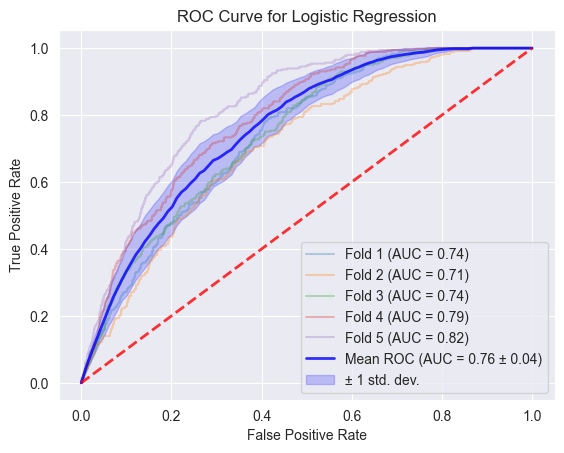

Evaluating Random Forest with cross-validation...


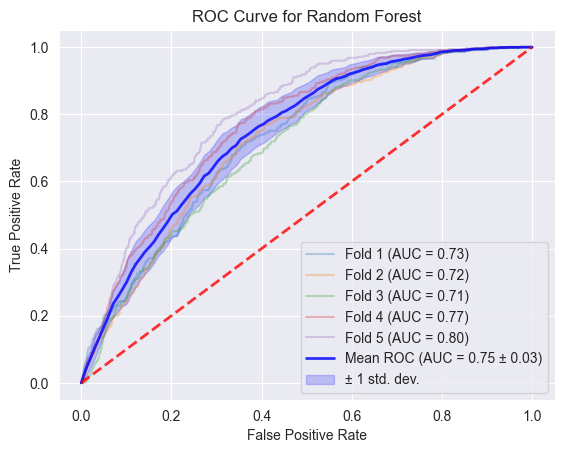

Evaluating Neural Network with cross-validation...


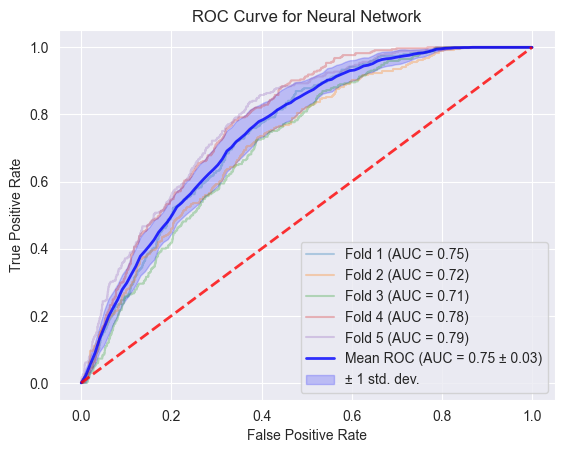

Evaluating K-Nearest Neighbors with cross-validation...


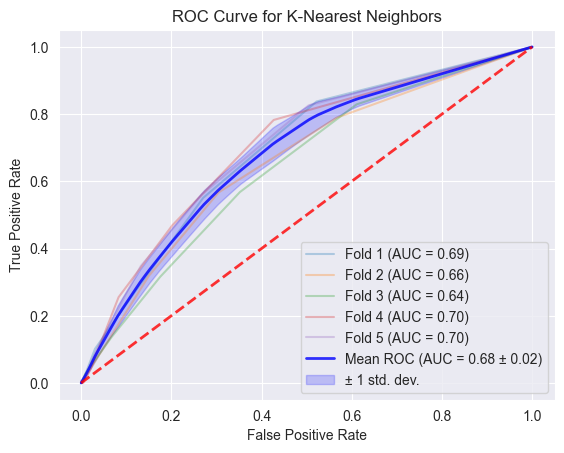

Evaluating Decision Tree with cross-validation...


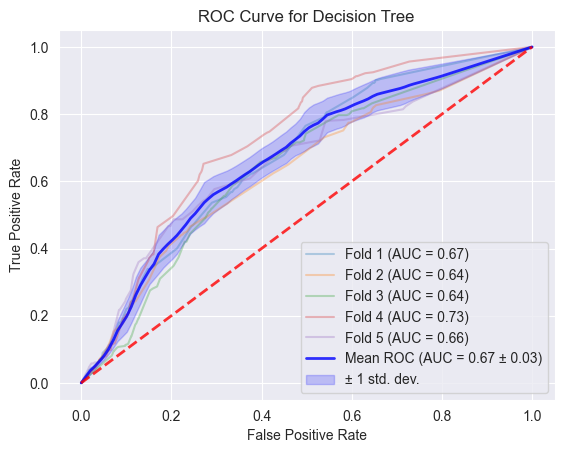

Evaluating Naive Bayes with cross-validation...


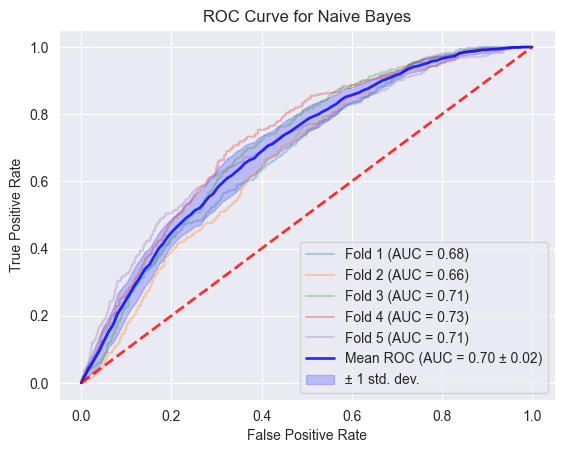

Evaluating XG Boost with cross-validation...


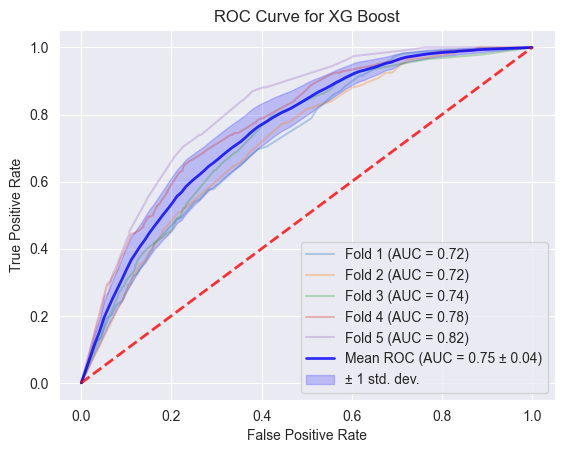

Evaluating Light Gradient Boosting Machine with cross-validation...
[LightGBM] [Info] Number of positive: 1381, number of negative: 7964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 9345, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.147780 -> initscore=-1.752124
[LightGBM] [Info] Start training from score -1.752124
[LightGBM] [Info] Number of positive: 1380, number of negative: 7965
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 9345, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.147673 -> initscore=-1.752973
[Lig

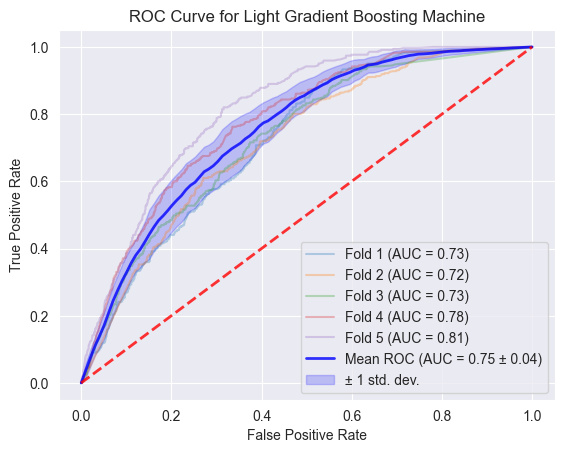

Mean ROC AUC for each model:
Logistic Regression: Mean ROC AUC = 0.7622
Random Forest: Mean ROC AUC = 0.7461
Neural Network: Mean ROC AUC = 0.7516
K-Nearest Neighbors: Mean ROC AUC = 0.6803
Decision Tree: Mean ROC AUC = 0.6676
Naive Bayes: Mean ROC AUC = 0.6988
XG Boost: Mean ROC AUC = 0.7540
Light Gradient Boosting Machine: Mean ROC AUC = 0.7537
Metrics for Logistic Regression: {'accuracy': np.float64(0.8503682202917918), 'precision': np.float64(0.777640116031771), 'recall': np.float64(0.8503682202917918), 'f1_score': np.float64(0.7903024282963823)}
Metrics for Random Forest: {'accuracy': np.float64(0.8507103563285092), 'precision': np.float64(0.7360309383363083), 'recall': np.float64(0.8507103563285092), 'f1_score': np.float64(0.7836663492320162)}
Metrics for Neural Network: {'accuracy': np.float64(0.8456591330062544), 'precision': np.float64(0.7640521145160539), 'recall': np.float64(0.8456591330062544), 'f1_score': np.float64(0.7870795446574065)}
Metrics for K-Nearest Neighbors: {'a

In [46]:
metrics = {}
X = np.array(X)  
y = np.array(y)  
cv = StratifiedKFold(n_splits=5)

mean_roc_auc = {}  # Dictionary to store mean ROC AUC for each model

for name, classifier in classifiers.items():
    print(f"Evaluating {name} with cross-validation...")
    classifier.set_params(**{key.split('__')[1]: value for key, value in best_params[name].items()})

    # Arrays to store metrics for each fold
    accuracies, precisions, recalls, f1_scores = [], [], [], []
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)

    plt.figure()
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y), start=1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Fit model
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        y_proba = classifier.predict_proba(X_test) if hasattr(classifier, 'predict_proba') else None

        # Compute metrics
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, average='weighted'))
        recalls.append(recall_score(y_test, y_pred, average='weighted'))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

        # Compute ROC curve
        if y_proba is not None:
            if len(np.unique(y)) > 2:  # Multi-class case
                y_test_bin = label_binarize(y_test, classes=np.unique(y))
                fpr, tpr, _ = roc_curve(y_test_bin[:, 1], y_proba[:, 1])
            else:  # Binary classification
                fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])

            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, alpha=0.3, label=f'Fold {fold_idx} (AUC = {roc_auc:.2f})')

    # Compute mean and standard deviation for ROC AUC
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    mean_roc_auc[name] = mean_auc  # Store mean ROC AUC for this model
    
    # Plot mean ROC curve
    if tprs:
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2, alpha=0.8)
        plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0), mean_tpr + np.std(tprs, axis=0), color='b', alpha=0.2, label='± 1 std. dev.')

    plt.plot([0, 1], [0, 1], linestyle='--', color='r', lw=2, alpha=0.8)
    plt.title(f'ROC Curve for {name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    # Store average metrics
    metrics[name] = {
        'accuracy': np.mean(accuracies),
        'precision': np.mean(precisions),
        'recall': np.mean(recalls),
        'f1_score': np.mean(f1_scores)
    }

# Print mean ROC AUC for each model
print("Mean ROC AUC for each model:")
for model, auc in mean_roc_auc.items():
    print(f"{model}: Mean ROC AUC = {auc:.4f}")

# Print metrics 
for model, metric in metrics.items():
    print(f"Metrics for {model}: {metric}")


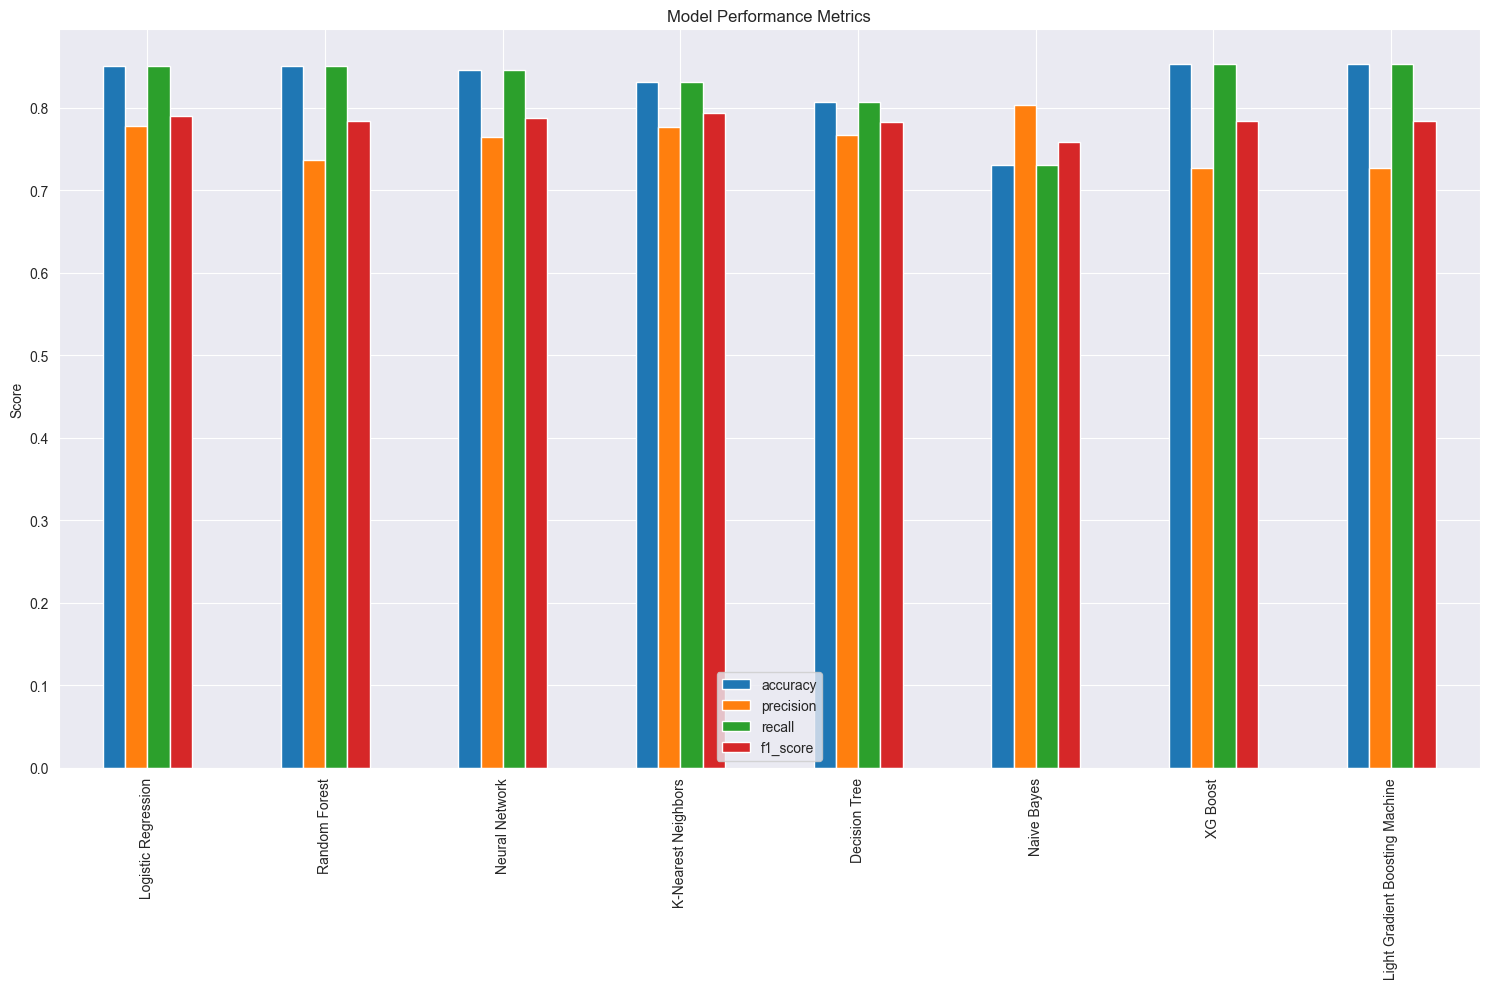

In [47]:
# Visualize the metrics
metrics_df = pd.DataFrame(metrics).T
metrics_df.plot(kind='bar', figsize=(15, 10))
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.tight_layout()
plt.show()


In [48]:
# print the metric in tabular format
metrics_df

accuracy  precision    recall  f1_score
Logistic Regression              0.850368   0.777640  0.850368  0.790302
Random Forest                    0.850710   0.736031  0.850710  0.783666
Neural Network                   0.845659   0.764052  0.845659  0.787080
K-Nearest Neighbors              0.831022   0.776782  0.831022  0.793977
Decision Tree                    0.806967   0.766202  0.806967  0.782860
Naive Bayes                      0.729844   0.803459  0.729844  0.757761
XG Boost                         0.852251   0.726332  0.852251  0.784270
Light Gradient Boosting Machine  0.852251   0.726332  0.852251  0.784270

In [49]:
# Drop Naive Bayes from the classifiers


In [50]:
# Explainability and Visualization

# Use SHAP values to explain model predictions and feature importance.

# Load Preprocessed Data

# PCA-transformed dataset
X = data_preprocessed.drop(columns=['Classification']).values
y = data_preprocessed['Classification'].values

# Pick one of your trained models (e.g., Random Forest) to explain its predictions.
model = classifiers['Logistic Regression']  # Replace with the desired model

# SHAP will interpret the model's predictions by assigning importance scores to features.
# Initialize SHAP Explainer
explainer = shap.Explainer(model, X)
shap_values = explainer(X)


In [51]:
print("Shape of shap_values:", shap_values.shape)
print("Shape of X:", X.shape)
print("Number of feature names:", len([f'PCA_{i+1}' for i in range(X.shape[1])]))


Shape of shap_values: (11682, 13)
Shape of X: (11682, 13)
Number of feature names: 13


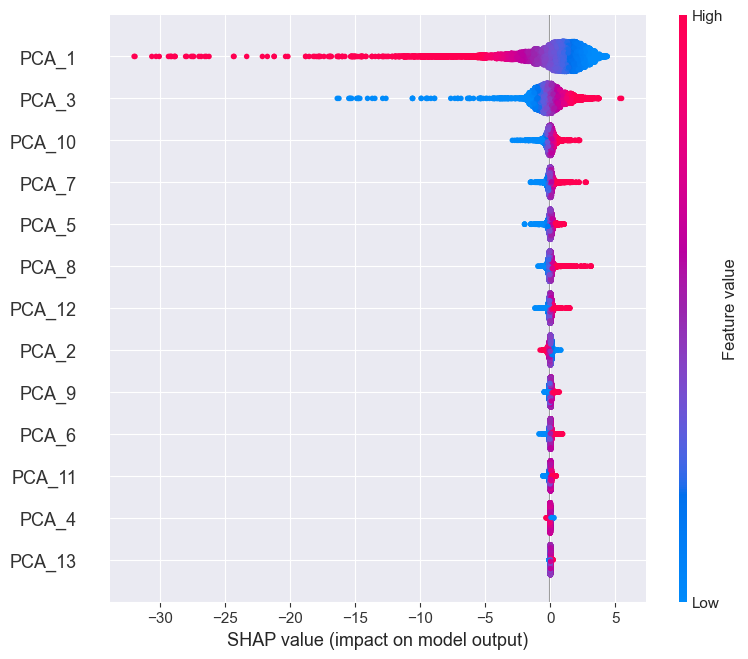

In [52]:
# Visualize Feature Importance

# Summary Plot: Displays the overall importance of features in the dataset.
shap.summary_plot(shap_values, X, feature_names=[f'PCA_{i+1}' for i in range(X.shape[1])])



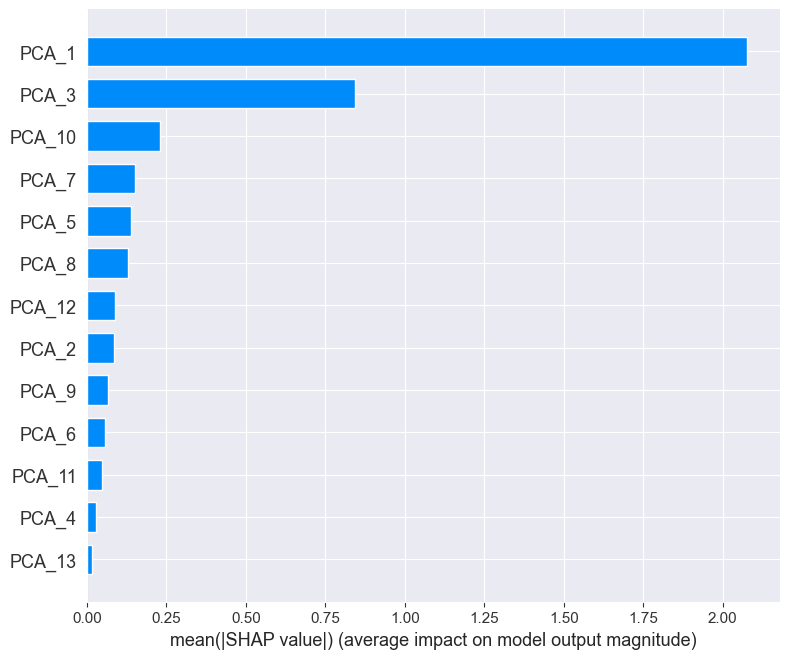

In [53]:
# Bar Plot: Highlights the top features in descending order of importance.

shap.summary_plot(shap_values, X, plot_type='bar', feature_names=[f'PCA_{i+1}' for i in range(X.shape[1])])


In [54]:
# # Dependence Plot: Shows how a specific feature influences predictions.
# 
# shap.dependence_plot(0, shap_values, X, feature_names=[f'PCA_{i+1}' for i in range(X.shape[1])])

In [55]:
# Retrieve PCA components and their contribution to original features
pca_components = pca.components_
original_features = ['population', 'poverty.rate',
       'renter.occupied.households', 'pct.renter.occupied',
       'median.gross.rent', 'median.household.income', 'median.property.value',
       'rent.burden', 'pct.white', 'pct.af.am', 'pct.hispanic', 'pct.am.ind',
       'pct.asian', 'pct.nh.pi', 'pct.multiple', 'pct.other',
       'eviction.filings', 'evictions', 'eviction.rate',
       'eviction.filing.rate',
       'ZHVI']

# Map top PCA components to original features
for i, component in enumerate(pca_components[:13]):  # Top 13 PCA components
    print(f"PCA_{i+1} Contributions:")
    for j, feature in enumerate(original_features):
        print(f"{feature}: {component[j]:.4f}")
    print('\n')


PCA_1 Contributions:
population: 0.3195
poverty.rate: -0.0354
renter.occupied.households: 0.3149
pct.renter.occupied: 0.2276
median.gross.rent: 0.2930
median.household.income: 0.1845
median.property.value: 0.2440
rent.burden: 0.1718
pct.white: -0.1580
pct.af.am: 0.1217
pct.hispanic: 0.0703
pct.am.ind: -0.0176
pct.asian: 0.2764
pct.nh.pi: 0.0809
pct.multiple: 0.1535
pct.other: 0.1633
eviction.filings: 0.2945
evictions: 0.3001
eviction.rate: 0.2429
eviction.filing.rate: 0.2474
ZHVI: 0.2482


PCA_2 Contributions:
population: 0.0911
poverty.rate: 0.4562
renter.occupied.households: 0.1115
pct.renter.occupied: 0.1653
median.gross.rent: -0.2587
median.household.income: -0.4151
median.property.value: -0.3301
rent.burden: 0.0540
pct.white: -0.3544
pct.af.am: 0.2886
pct.hispanic: 0.1842
pct.am.ind: 0.1150
pct.asian: -0.0701
pct.nh.pi: -0.0395
pct.multiple: -0.0533
pct.other: 0.0143
eviction.filings: 0.1560
evictions: 0.1502
eviction.rate: 0.0647
eviction.filing.rate: 0.0905
ZHVI: -0.2608


PCA_3

In [56]:
# PCA Components and Original Features
pca_components = pca.components_
numerical_features = ['population', 'poverty.rate',
       'renter.occupied.households', 'pct.renter.occupied',
       'median.gross.rent', 'median.household.income', 'median.property.value',
       'rent.burden', 'pct.white', 'pct.af.am', 'pct.hispanic', 'pct.am.ind',
       'pct.asian', 'pct.nh.pi', 'pct.multiple', 'pct.other',
       'eviction.filings', 'evictions', 'eviction.rate',
       'eviction.filing.rate',
       'ZHVI']

# Map PCA components to original features
contributions = pd.DataFrame(pca_components.T, index=original_features, columns=[f'PCA_{i+1}' for i in range(pca_components.shape[0])])
print("Contributions of Original Features to PCA Components:")
contributions

# Map original features to PCA components 
contributions.T
# do summation for each column in the table from contributions.T




Contributions of Original Features to PCA Components:


population  poverty.rate  renter.occupied.households  \
PCA_1     0.319455     -0.035380                    0.314871   
PCA_2     0.091053      0.456160                    0.111493   
PCA_3    -0.329575      0.199146                   -0.334665   
PCA_4    -0.049154     -0.073519                   -0.067480   
PCA_5    -0.050119     -0.108594                   -0.062549   
PCA_6    -0.070178     -0.131410                   -0.092553   
PCA_7    -0.084818     -0.156244                   -0.115020   
PCA_8    -0.060843      0.002873                   -0.044558   
PCA_9     0.037943     -0.076116                    0.021567   
PCA_10   -0.035275     -0.170846                   -0.015676   
PCA_11   -0.086618      0.123597                   -0.048079   
PCA_12    0.084768      0.122060                    0.011260   
PCA_13    0.063813      0.354765                    0.035683   

        pct.renter.occupied  median.gross.rent  median.household.income  \
PCA_1              0.227583           0.293035                 0.184539   
PCA_2              0.165340          -0.258676                -0.415057   
PCA_3              0.116258           0.219678                -0.003614   
PCA_4             -0.169486          -0.047770                -0.048952   
PCA_5             -0.140335           0.089714                 0.158635   
PCA_6             -0.085042           0.007114                 0.224897   
PCA_7              0.044804          -0.051440                 0.041043   
PCA_8              0.118692          -0.112837                -0.117483   
PCA_9             -0.175697          -0.029625                 0.155634   
PCA_10             0.463736          -0.018981                 0.088304   
PCA_11             0.586457          -0.082137                -0.169428   
PCA_12            -0.306973           0.027889                 0.039535   
PCA_13            -0.362276          -0.236747                -0.239631   

        median.property.value  rent.burden  pct.white  pct.af.am  ...  \
PCA_1                0.243997     0.171805  -0.158023   0.121651  ...   
PCA_2               -0.330067     0.053975  -0.354370   0.288612  ...   
PCA_3                0.165803     0.361523  -0.256101   0.278745  ...   
PCA_4               -0.092208     0.089990   0.230725   0.260415  ...   
PCA_5                0.032144    -0.105136  -0.288959   0.083161  ...   
PCA_6               -0.032766    -0.404319  -0.194549  -0.100524  ...   
PCA_7               -0.189692    -0.231183  -0.007691  -0.189329  ...   
PCA_8               -0.080171    -0.058986   0.179871  -0.190223  ...   
PCA_9                0.009732    -0.275614  -0.175615   0.487779  ...   
PCA_10              -0.180761    -0.241252  -0.042655   0.233974  ...   
PCA_11               0.169868    -0.120112   0.162588  -0.242718  ...   
PCA_12              -0.151546     0.419563   0.064383  -0.269285  ...   
PCA_13               0.137994    -0.395347   0.018259  -0.022723  ...   

        pct.am.ind  pct.asian  pct.nh.pi  pct.multiple  pct.other  \
PCA_1    -0.017617   0.276396   0.080902      0.153474   0.163299   
PCA_2     0.114962  -0.070068  -0.039481     -0.053279   0.014275   
PCA_3     0.096304  -0.039961   0.068653      0.213011   0.085877   
PCA_4    -0.298618  -0.157971  -0.261646     -0.187314  -0.090953   
PCA_5    -0.451959   0.001934  -0.229446     -0.476851   0.137308   
PCA_6     0.601141  -0.046819  -0.433127      0.123798  -0.010486   
PCA_7    -0.127528   0.012467   0.680146      0.113632  -0.091647   
PCA_8    -0.064532   0.082704  -0.091519      0.077305   0.907275   
PCA_9     0.252681   0.231316   0.364223     -0.390862   0.207737   
PCA_10   -0.294477   0.473680  -0.259956      0.272742  -0.181801   
PCA_11    0.160614   0.111402   0.005426     -0.548689  -0.136390   
PCA_12    0.170683   0.639255  -0.074043     -0.198453  -0.087808   
PCA_13   -0.190368   0.301703  -0.012853      0.241313  -0.055502   

        eviction.filings  evictions  eviction.rate  eviction.filing.ra

In [57]:
# Compute summation for each column in the transposed contributions table
column_sums = contributions.T.sum(axis=0)


# Display the results
print("Summation for each column in contributions.T:")
print(column_sums)

Summation for each column in contributions.T:
population                   -0.169547
poverty.rate                  0.506491
renter.occupied.households   -0.285705
pct.renter.occupied           0.483062
median.gross.rent            -0.200783
median.household.income      -0.101576
median.property.value        -0.297674
rent.burden                  -0.735094
pct.white                    -0.822138
pct.af.am                     0.739534
pct.hispanic                  0.311106
pct.am.ind                   -0.048714
pct.asian                     1.816040
pct.nh.pi                    -0.202719
pct.multiple                 -0.660173
pct.other                     0.861183
eviction.filings             -0.444070
evictions                    -0.459688
eviction.rate                 1.592473
eviction.filing.rate          1.711997
ZHVI                          0.078633
dtype: float64


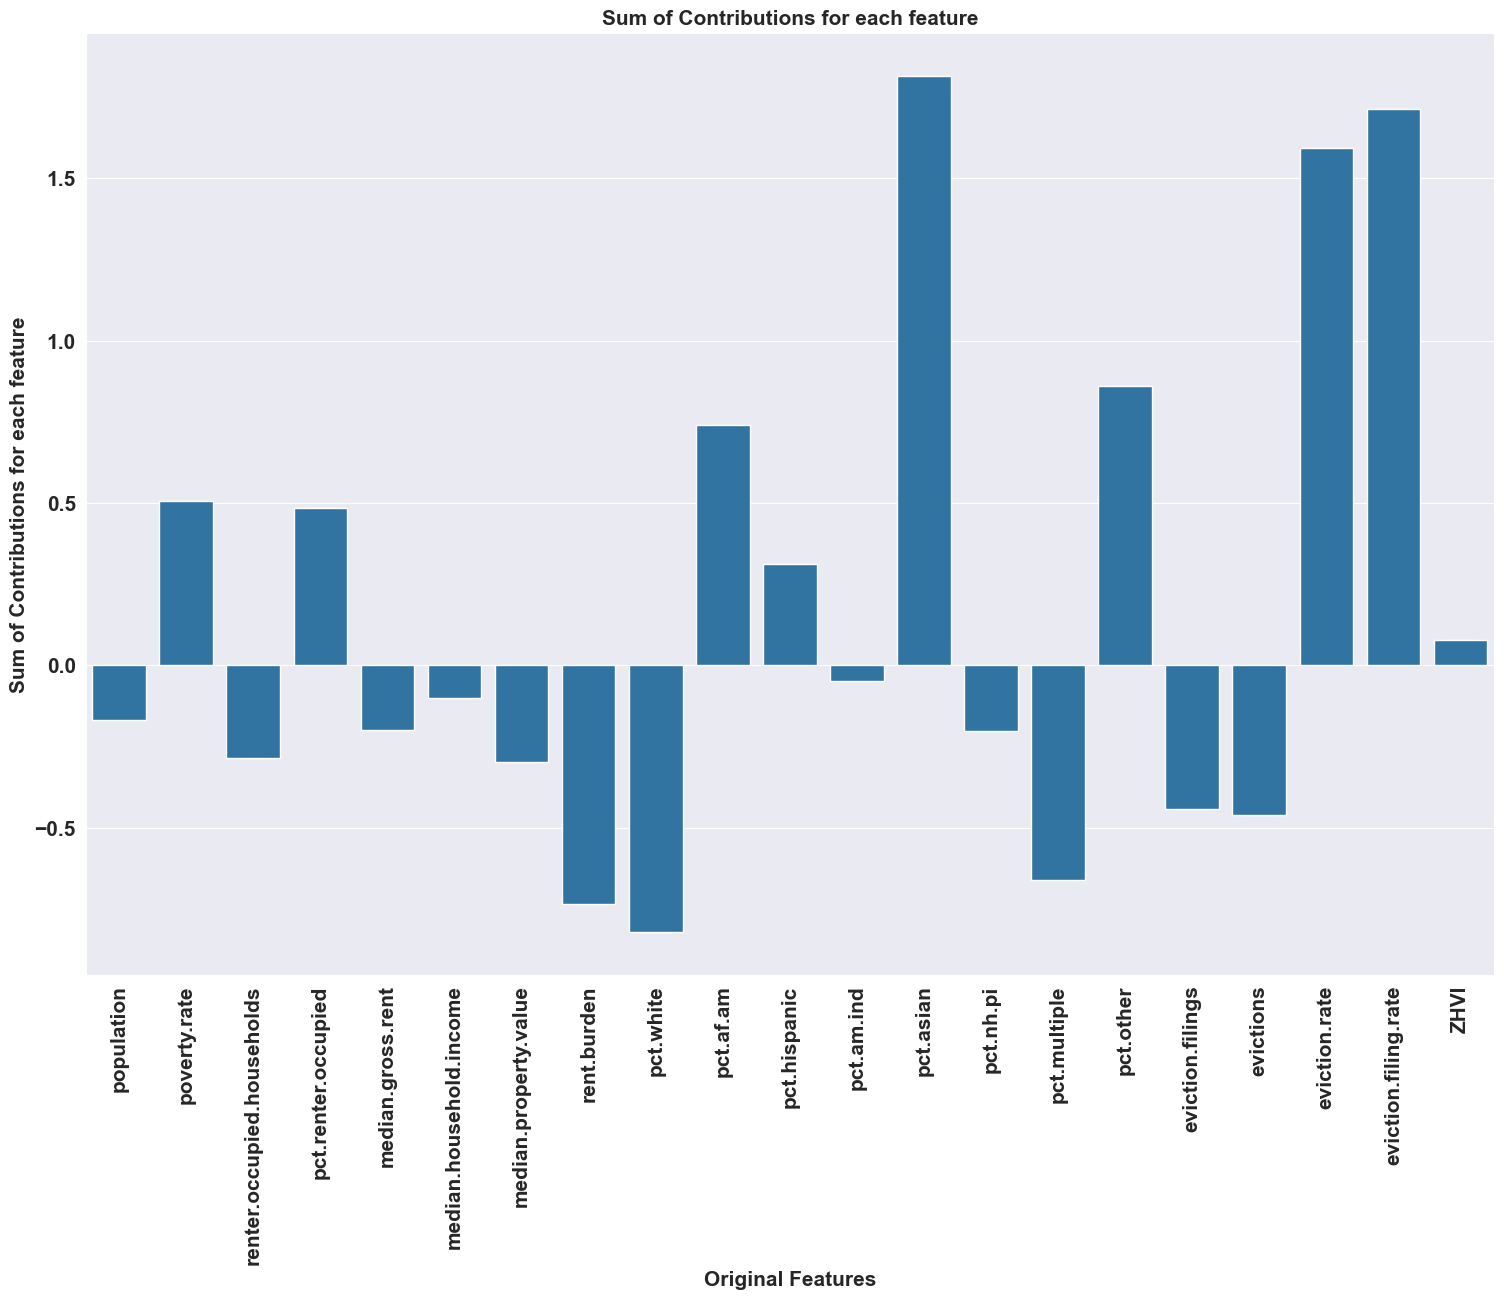

In [58]:
# Bar plot of the summation values

# For the plot, label's text should be bold and font size should be 15. 


plt.figure(figsize=(15, 12))
column_sums.plot(kind='bar')
sns.barplot(x=column_sums.index, y=column_sums.values)
#Make xlabel, ylabel and title bold and font size 15
plt.xlabel('Original Features', fontweight='bold', fontsize=15)
plt.ylabel('Sum of Contributions for each feature', fontweight='bold', fontsize=15)
plt.title('Sum of Contributions for each feature', fontweight='bold', fontsize=15)
plt.tight_layout()

# Set the properties of the tick labels
plt.setp(plt.gca().get_xticklabels(), fontsize=15, fontweight='bold')
# do same for y-axis and other labels too
plt.setp(plt.gca().get_yticklabels(), fontsize=15, fontweight='bold')
plt.show()

In [59]:
    # Plot the SHAP values for a specific feature

# I want to have a table where each rows are for each PCA component and the columns are the original features. Each cell represents contribution of each original feature to each PCA component.




In [60]:

# LGBBM, RF, Naivae BAyes, LR


In [61]:
def explain_model_with_shap(model, X, pca_components, original_features, model_name):

    
    explainer = shap.TreeExplainer(model, X)
    shap_values = explainer(X)

    shap.summary_plot(shap_values, X, feature_names=[f'PCA_{i+1}' for i in range(X.shape[1])])
    shap.summary_plot(shap_values, X, plot_type='bar', feature_names=[f'PCA_{i+1}' for i in range(X.shape[1])])

    # Map top PCA components to original features
    for i, component in enumerate(pca_components[:13]):  # Top 13 PCA components
        print(f"PCA_{i+1} Contributions:")
        for j, feature in enumerate(original_features):
            print(f"{feature}: {component[j]:.4f}")
        print('\n')

    # Map PCA components to original features
    contributions = pd.DataFrame(pca_components.T, index=original_features, columns=[f'PCA_{i+1}' for i in range(pca_components.shape[0])])
    print("Contributions of Original Features to PCA Components:")
    print(contributions.head())

    # Map original features to PCA components 
    print(contributions.T.head())

    # Compute summation for each column in the transposed contributions table
    column_sums = contributions.T.sum(axis=0)

    # Display the results
    print("Summation for each column in contributions.T:")
    print(column_sums)

    # Bar plot of the summation values

    plt.figure(figsize=(12, 8))
    column_sums.plot(kind='bar')
    plt.title(f'Summation of Contributions to PCA Components for {model_name}')
    plt.xlabel('PCA Components')
    plt.ylabel('Summation')
    plt.tight_layout()
    plt.show()

    return None

In [62]:
# PCA-transformed dataset
X = data_preprocessed.drop(columns=['Classification']).values
y = data_preprocessed['Classification'].values
pca_components = pca.components_
original_features = ['population', 'poverty.rate',
       'renter.occupied.households', 'pct.renter.occupied',
       'median.gross.rent', 'median.household.income', 'median.property.value',
       'rent.burden', 'pct.white', 'pct.af.am', 'pct.hispanic', 'pct.am.ind',
       'pct.asian', 'pct.nh.pi', 'pct.multiple', 'pct.other',
       'eviction.filings', 'evictions', 'eviction.rate',
       'eviction.filing.rate',
       'ZHVI']



In [63]:
# # Pick one of your trained models (e.g., Random Forest) to explain its predictions.
# model = classifiers['Random Forest']  # Replace with the desired model
# 
# # # Run for each models in a loop
# # for model_name, model in classifiers.items():
# #     print(f"Explaining model: {model_name}")
# #     explain_model_with_shap(model, X, pca_components, original_features, model_name=model_name)
# 
# explain_model_with_shap(model, X, pca_components, original_features, model_name='Random Forest')